In [1]:
import numpy as np
import scipy
import matplotlib as mpl
from dolfinx import fem, mesh
from dataclasses import dataclass
from mpi4py import MPI
from src.solutionOperators import getSourceTerm, solveStateEquation, buildControlFunction, solveAdjointEquation
from src.visualization import plot_array, printIterationInfo, timeDependentVariableToGif
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import HesseMatrix
from src.osqp import computeOSQPStep
from src.iterationHelpers import pruneActiveSet, calculateDiscreteGradient, integrateVectorFunction, getIdxMax
from src.helpers import buildIterationFunction, computeObjective, linCombFunctionLists
from typing import List

@dataclass
class Parameters:
    T = 1
    dt = 0.01
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.1
    newton_c = 100
    eta = 0.01
    alpha = 1e-8
    beta = 1e-7
    waveSpeed = 2
    randomFactor = 0.00
    maxIterations = 50
    pruneThreshold = 1e-7
    yd = []
    yd_adjoint = []
    standardInnerProducts = None
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1.0, 1.0)),
        n=(32, 32),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))
    
params = Parameters()

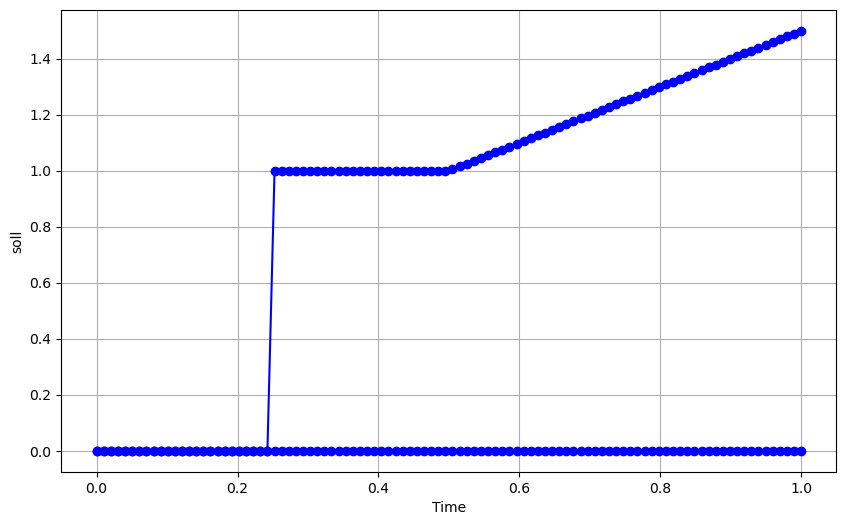

In [2]:
ext1 = ExtremalPoint(np.array([1., 0]), x_0=0.25, type=0, params=params)
ext2 = ExtremalPoint(np.array([1., 0]), x_0=0.5, type=1, params=params)
s1 = lambda t : ext1.value(t)[0] * params.alpha + ext2.value(t)[0] * params.beta#0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35)) / params.alpha
s2 = lambda t : 0#0.775 if t <= 0.25 else (-0.025 if t <= 0.5 else (0.975 if t <= 0.75 else 0.275)) / params.alpha
g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
control = buildControlFunction([g1, g2], [s1, s2], params)
K_u = solveStateEquation(control, params)
grid_size = K_u[0].x.array.shape
raw_matrices = [K_u_t.x.array for K_u_t in K_u]
norms = [np.linalg.norm(matrix, ord=2) for matrix in raw_matrices]
scale = params.randomFactor * np.mean(norms) / grid_size[0] * params.area
np.random.seed(42)
yd = [fem.Function(params.V) for _ in K_u]
for idx in range(len(yd)):
    yd[idx].x.array[:] = K_u[idx].x.array + 0*np.random.normal(loc=0.0, scale=scale, size=grid_size)
params.yd = K_u
params.yd_adjoint = solveAdjointEquation(params.yd, params)
discretInterval = np.linspace(0, params.T, int(params.T/params.dt))
array = np.ndarray((int(params.T/params.dt), 2))
array[:, 0] = np.array([s1(t) for t in discretInterval])
array[:, 1] = np.array([s2(t) for t in discretInterval])
plot_array(array, params.T, label='soll')
#timeDependentVariableToGif(yd, 'output/observation.gif')

Objective upper bound:  0.015545004631931574
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4, constraints m = 4
          nnz(P) + nnz(A) = 14
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2363e-03   1.57e-17   3.64e-03   1.00e-01   6.80e-05s
  25  -1.9317e-03   4.44e-16   1.73e-08   1.00e-01   1.11e-04s

stat

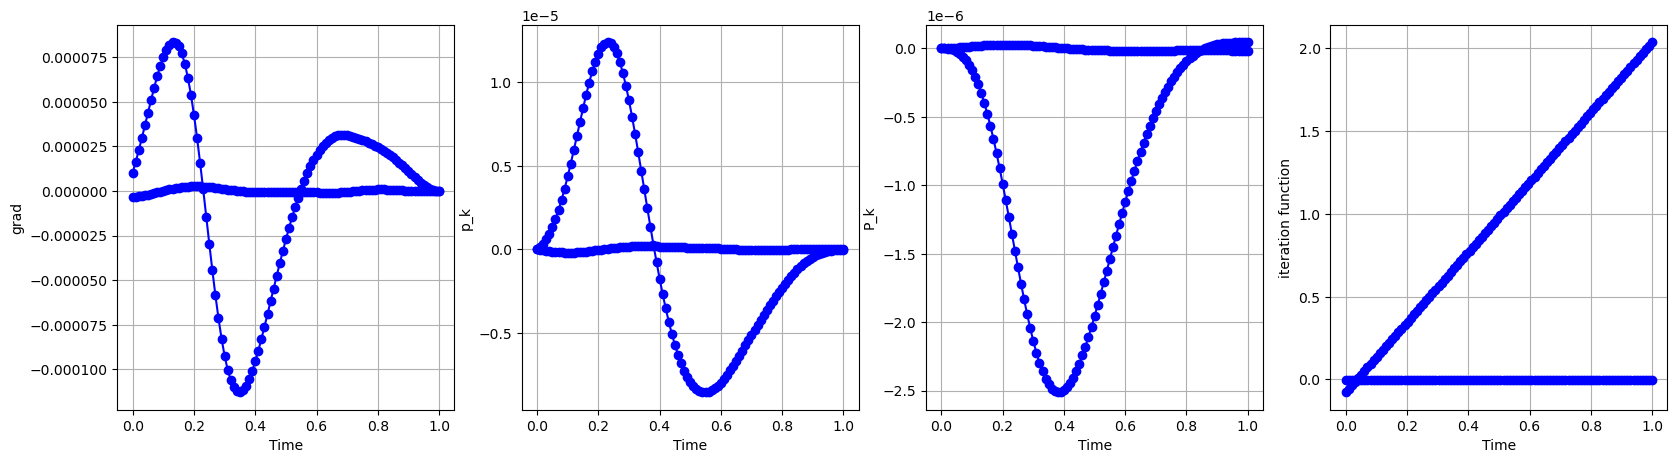

|p_max|/alpha:  1237.664864252249 , |P_max|/beta:  25.122895330149742
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999446 0.00332784] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          weights:  [7.74044672e-09] slope:  [ 0.72942094 -0.0098115 ] y_shift [-0.10000177  0.00313639]
eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off,

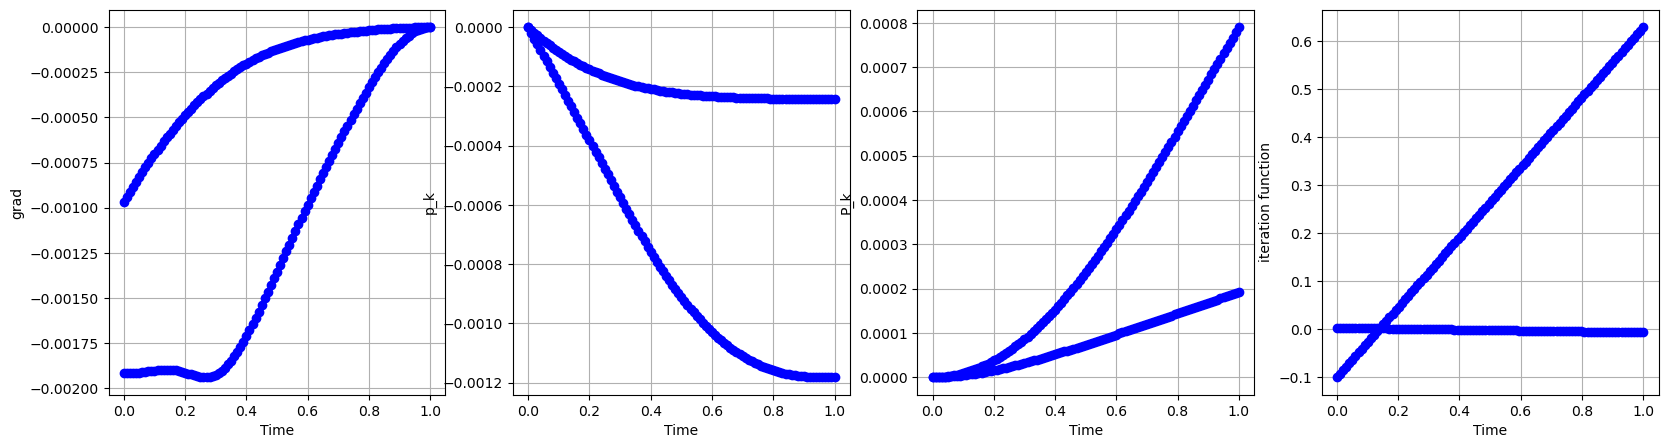

|p_max|/alpha:  120633.4074378271 , |P_max|/beta:  8009.852966168703
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.97964528 -0.20073647] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
weights:  [0.] slo

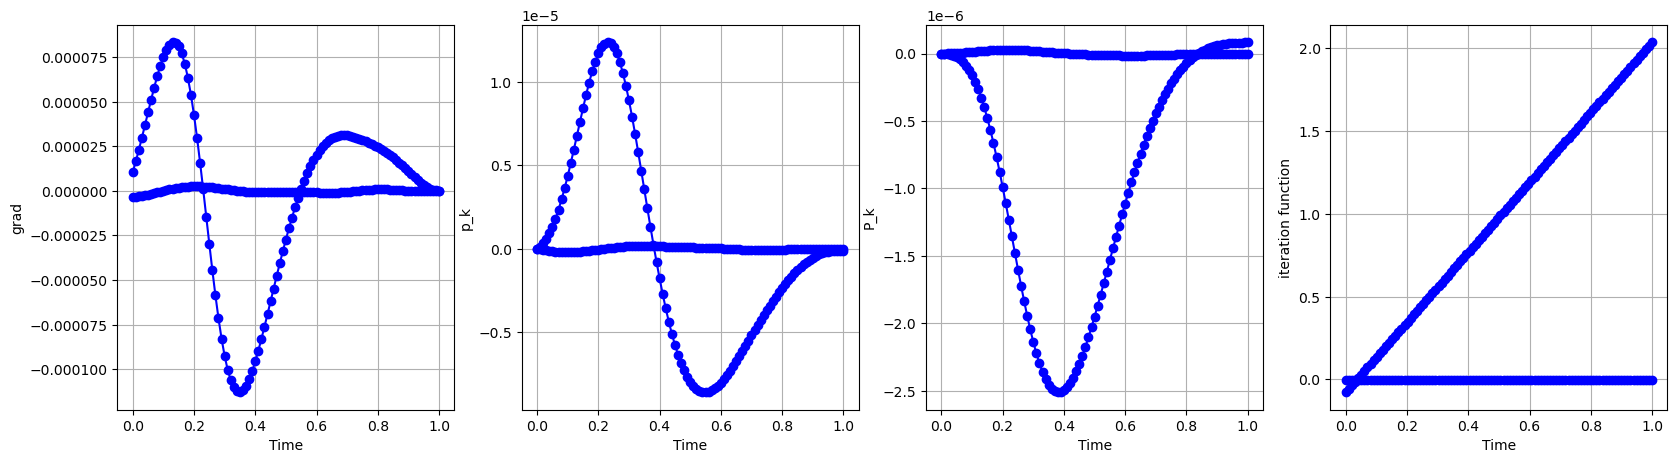

|p_max|/alpha:  1237.015698775931 , |P_max|/beta:  25.09812403607053
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275037] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
weights:  [7.7404138

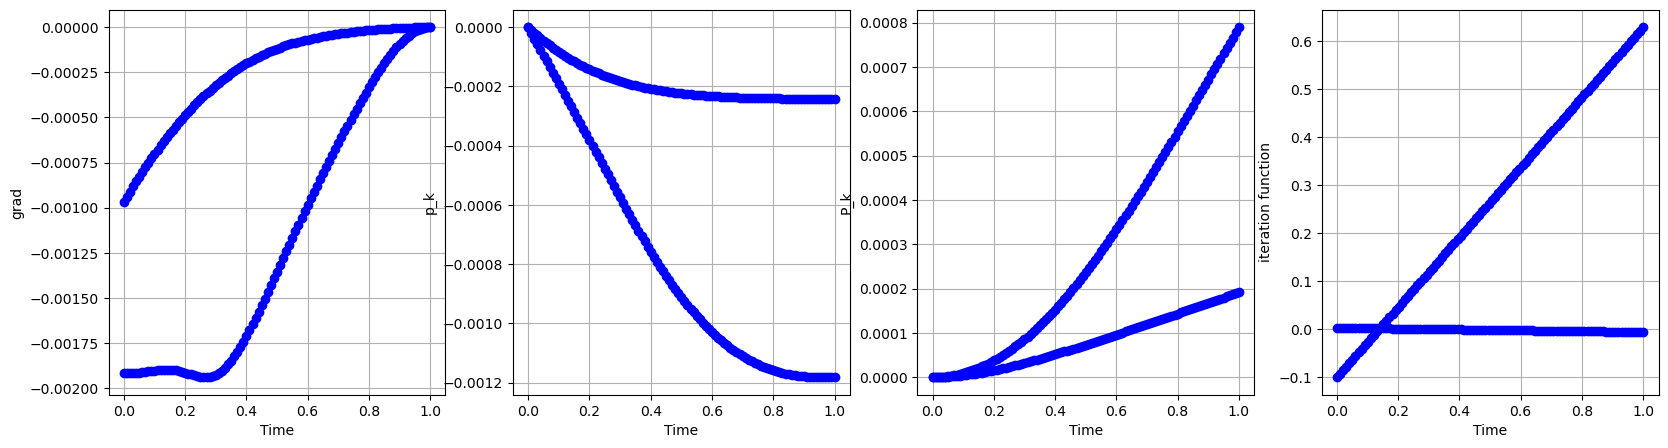

|p_max|/alpha:  120605.95623240956 , |P_max|/beta:  8007.718219346586
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.97975174 -0.20021622] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   weights:  [0.] slope:  [2.11244692 0.00534241] y_shift [-0.07723527 

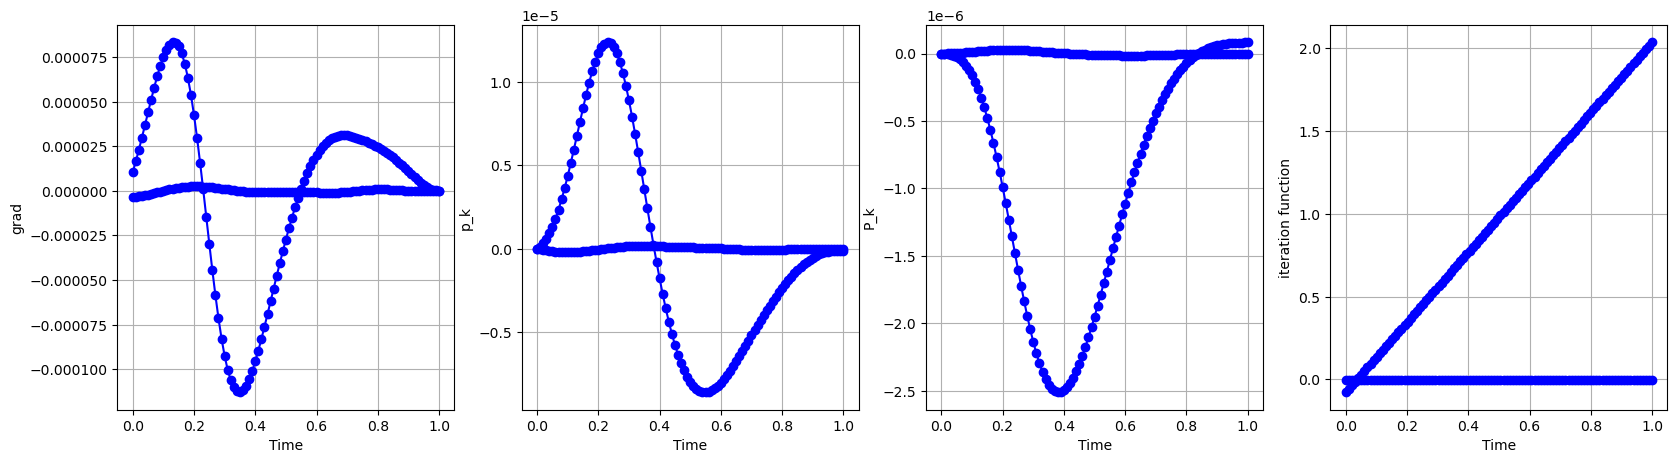

|p_max|/alpha:  1237.0159902920984 , |P_max|/beta:  25.098132455925732
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2525e-03 

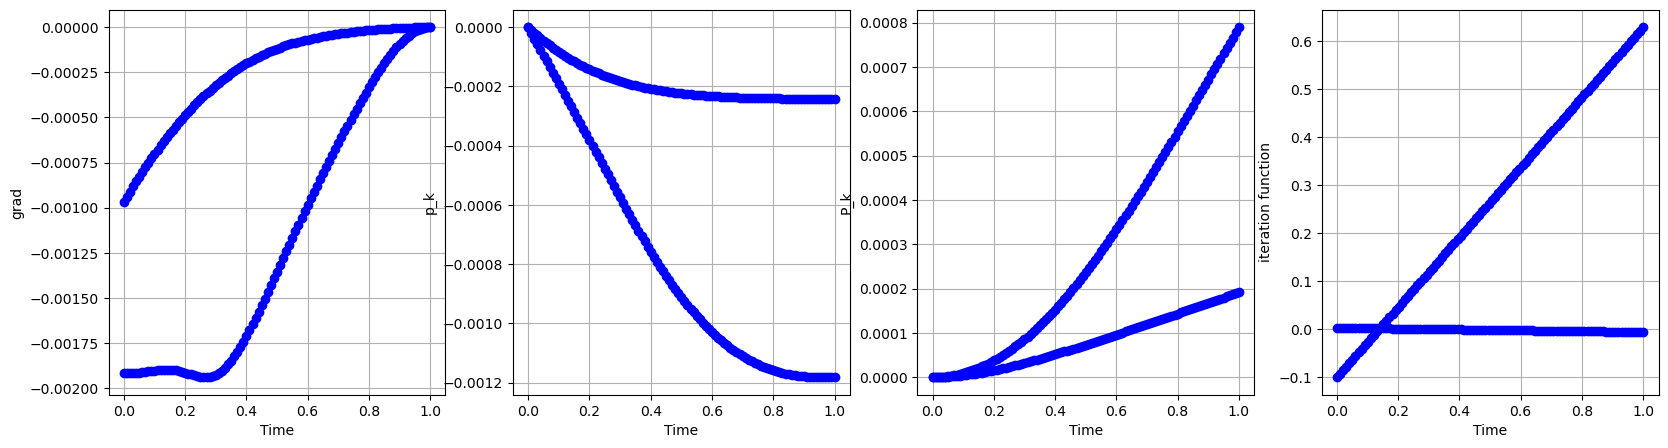

|p_max|/alpha:  120605.96533944433 , |P_max|/beta:  8007.71892749426
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
weights:  [0.] slope:  [2.11244692 0.00534241] y_shift [-0.07723527 -0.00606252]
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: 

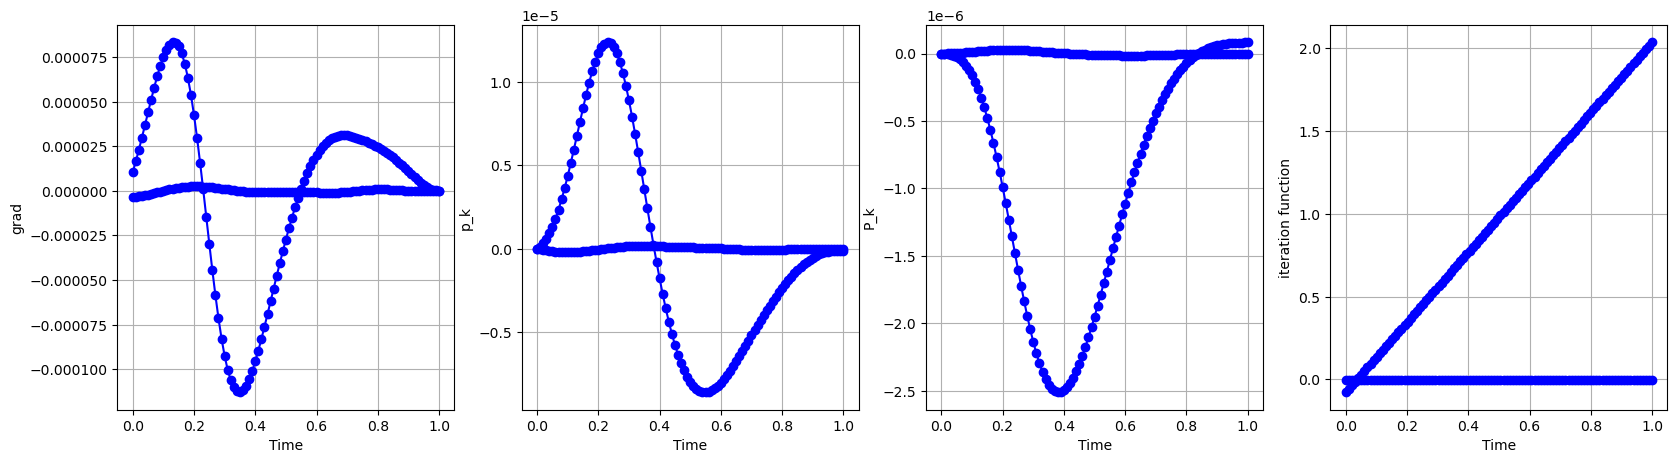

|p_max|/alpha:  1237.0159901953919 , |P_max|/beta:  25.098132453133086
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2525e-03 

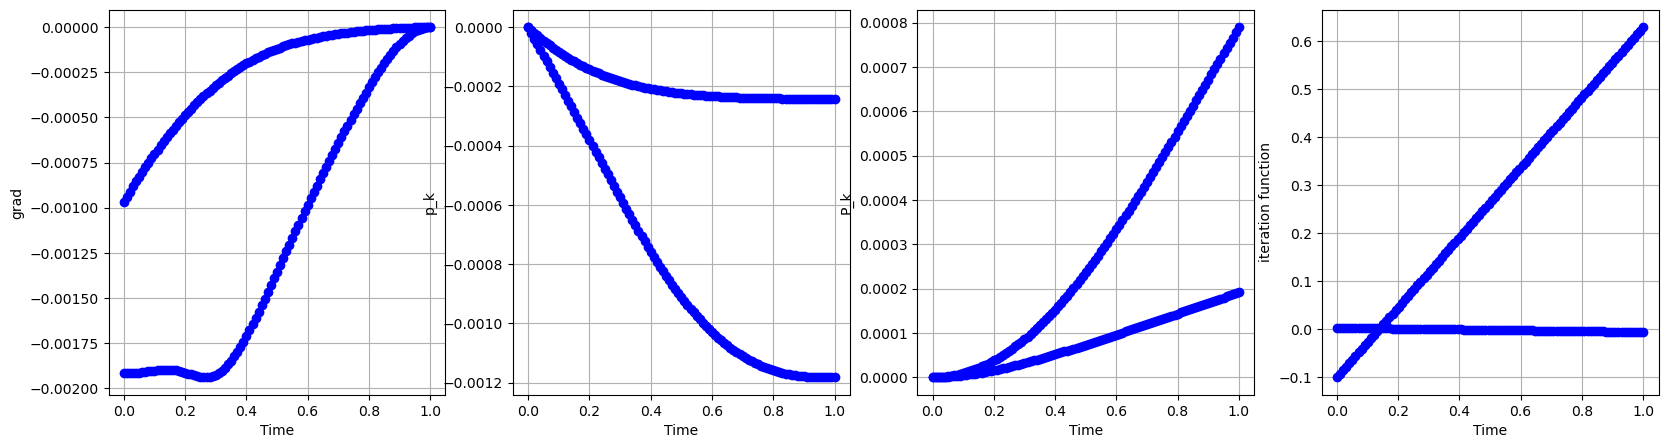

|p_max|/alpha:  120605.96533642808 , |P_max|/beta:  8007.718927259712
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2364e-03

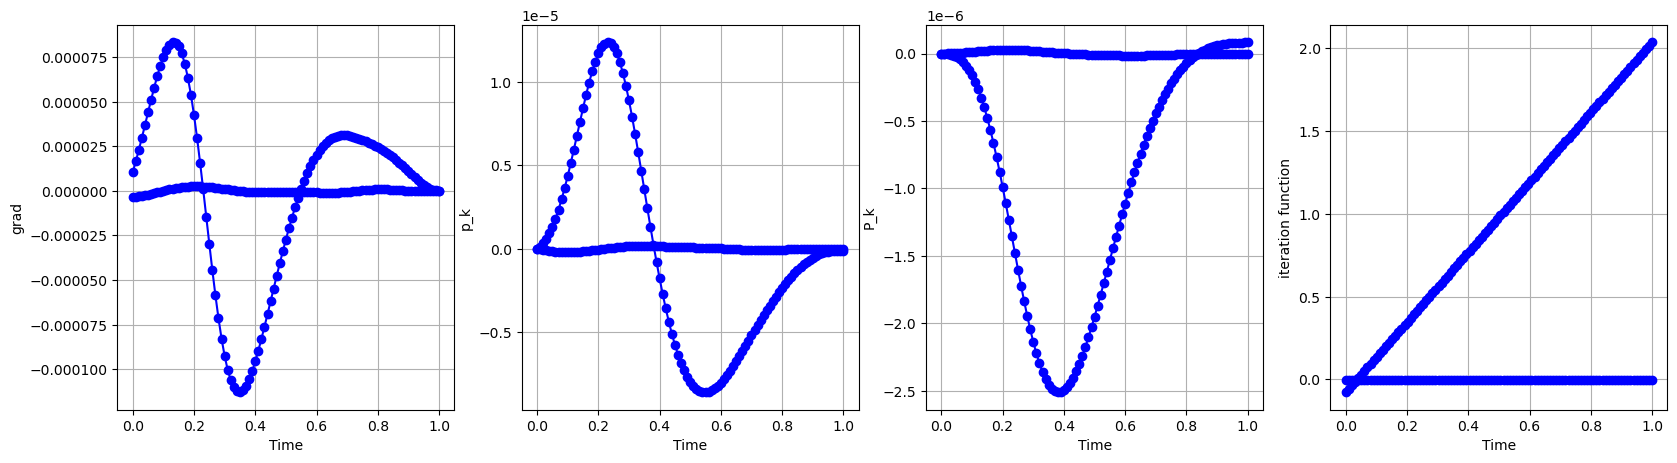

|p_max|/alpha:  1237.0159901954867 , |P_max|/beta:  25.0981324531359
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2525e-03wei

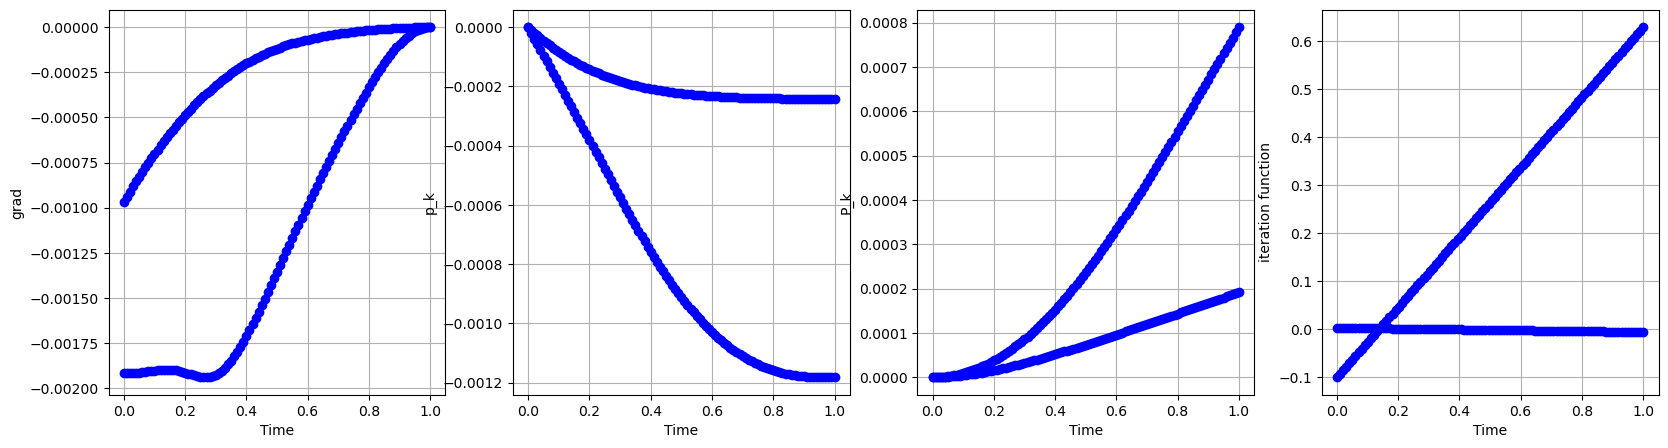

|p_max|/alpha:  120605.96533642511 , |P_max|/beta:  8007.718927259529
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          weights:  [0.] slope:  [2.11244692 0.00534241] y_shift [-0.07723527 -0.00606252]
eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit:

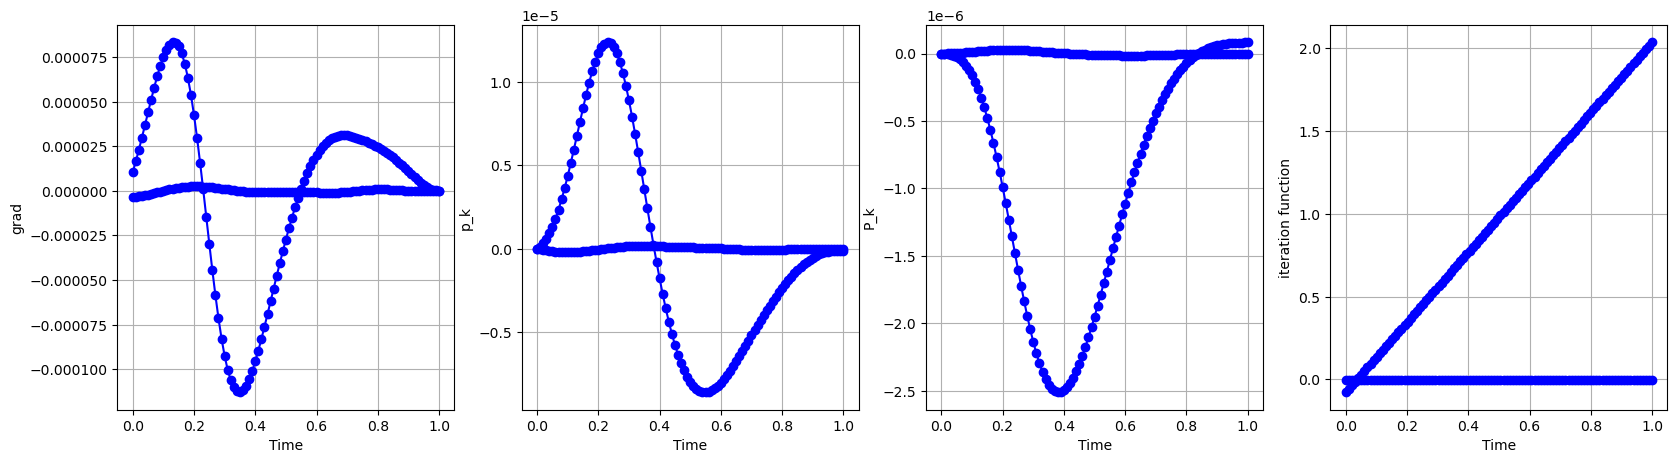

|p_max|/alpha:  1237.0159901955155 , |P_max|/beta:  25.09813245313669
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

weights:  [7.74041383e-09] slope:  [ 0.72943055 -0.00901272] y_shift [-0.1000

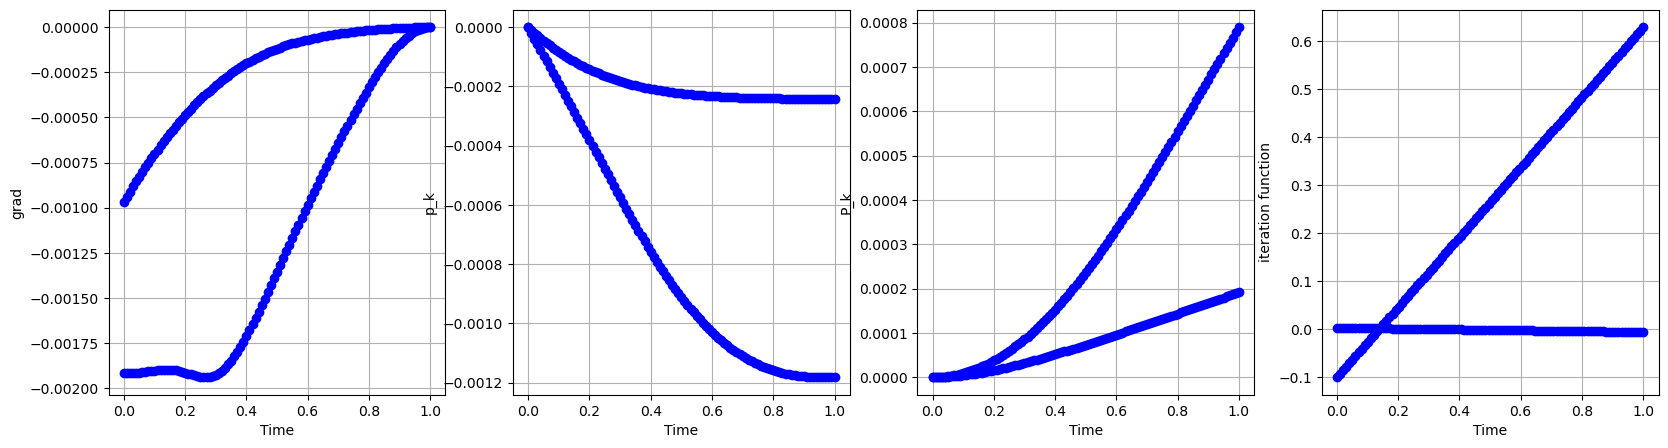

|p_max|/alpha:  120605.96533643108 , |P_max|/beta:  8007.718927259929
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2364e-03

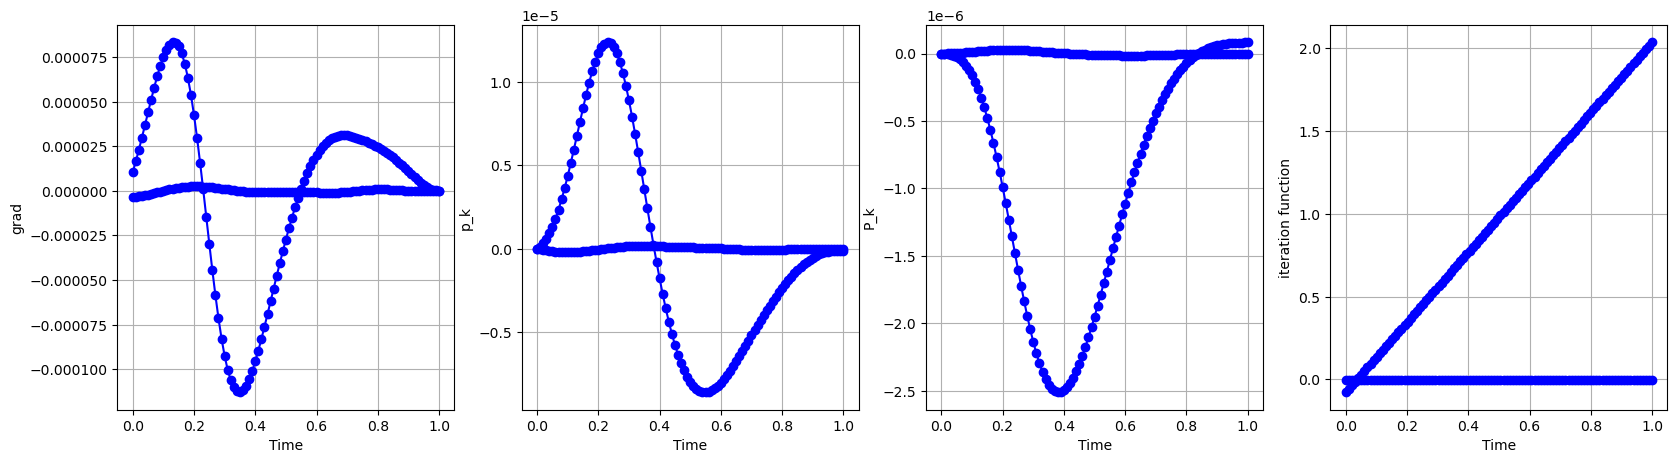

|p_max|/alpha:  1237.0159901954862 , |P_max|/beta:  25.098132453135843
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          weights:  [7.74041383e-09] slope:  [ 0.72943055 -0.00901272] y_shift [-0.10000708  0.00314943]
eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off

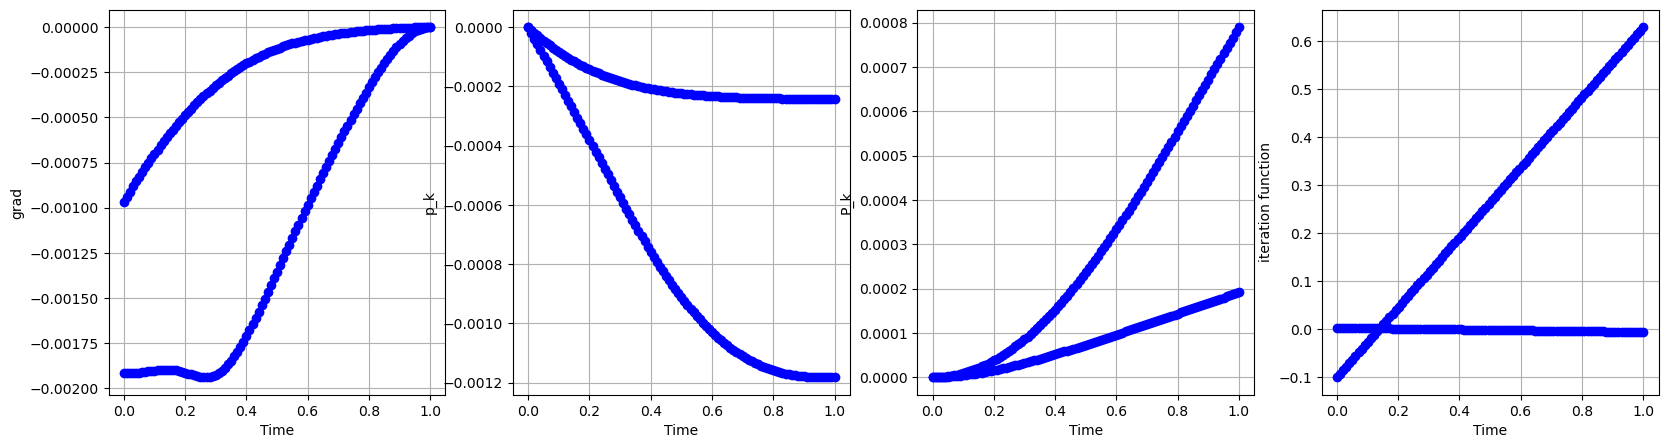

|p_max|/alpha:  120605.9653364259 , |P_max|/beta:  8007.718927259582
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  weights:  [0.] slope:  [2.11244692 0.00534241] y_shift [-0.07723527 -0.00606252]
variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: 

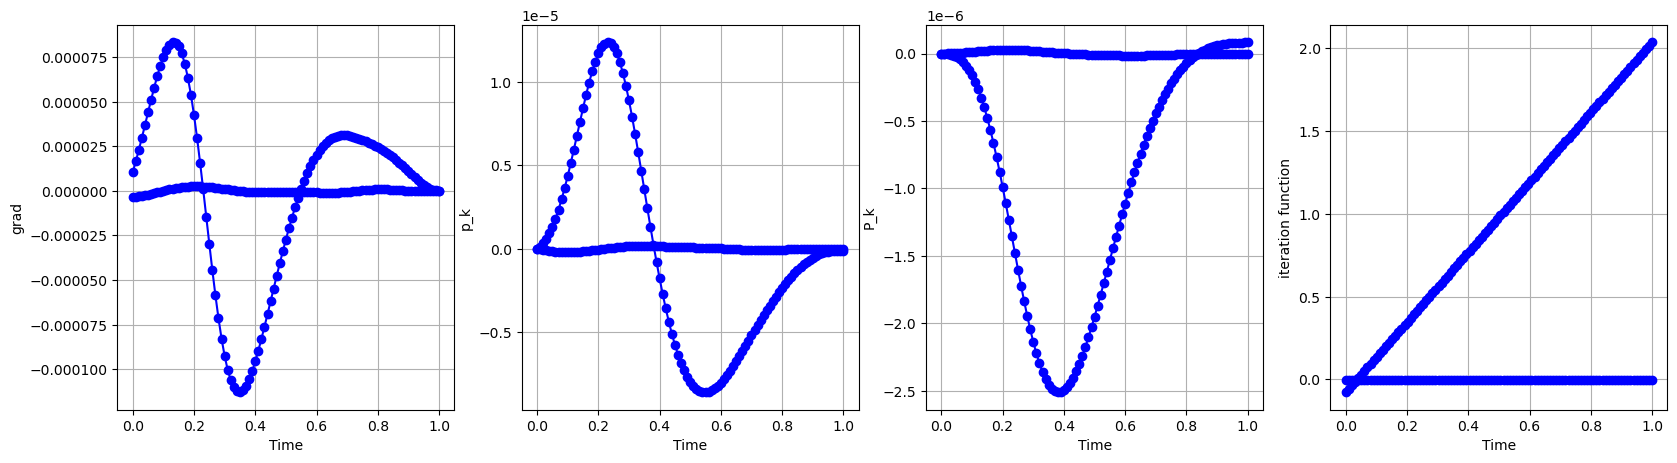

|p_max|/alpha:  1237.0159901955315 , |P_max|/beta:  25.098132453137115
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2525e-03 

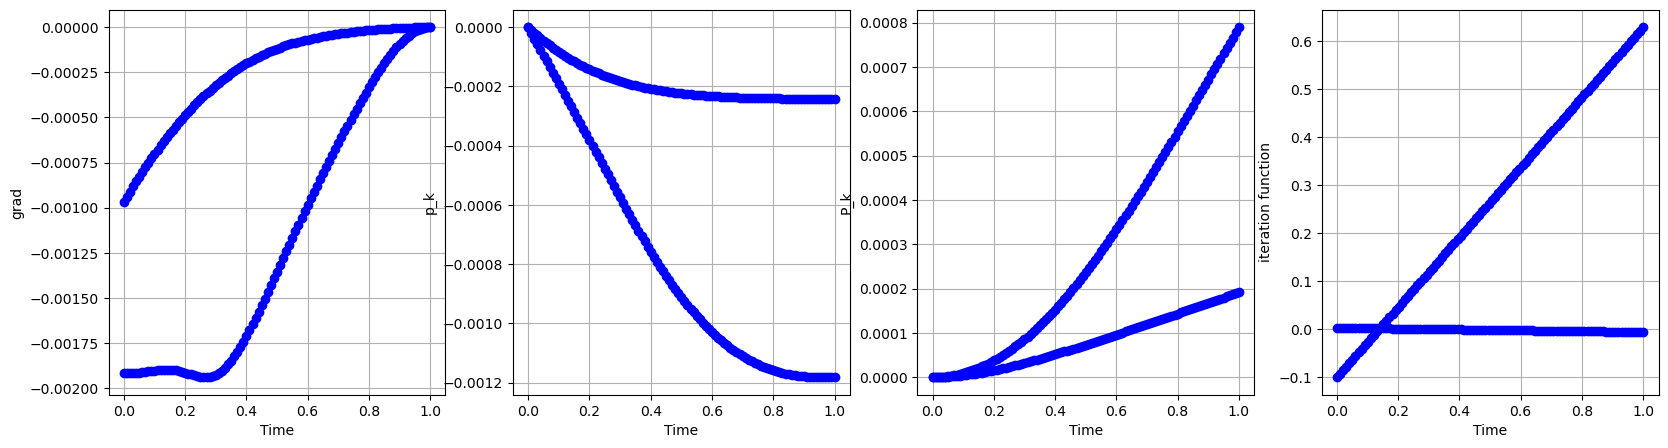

|p_max|/alpha:  120605.96533642776 , |P_max|/beta:  8007.718927259702
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2364e-03

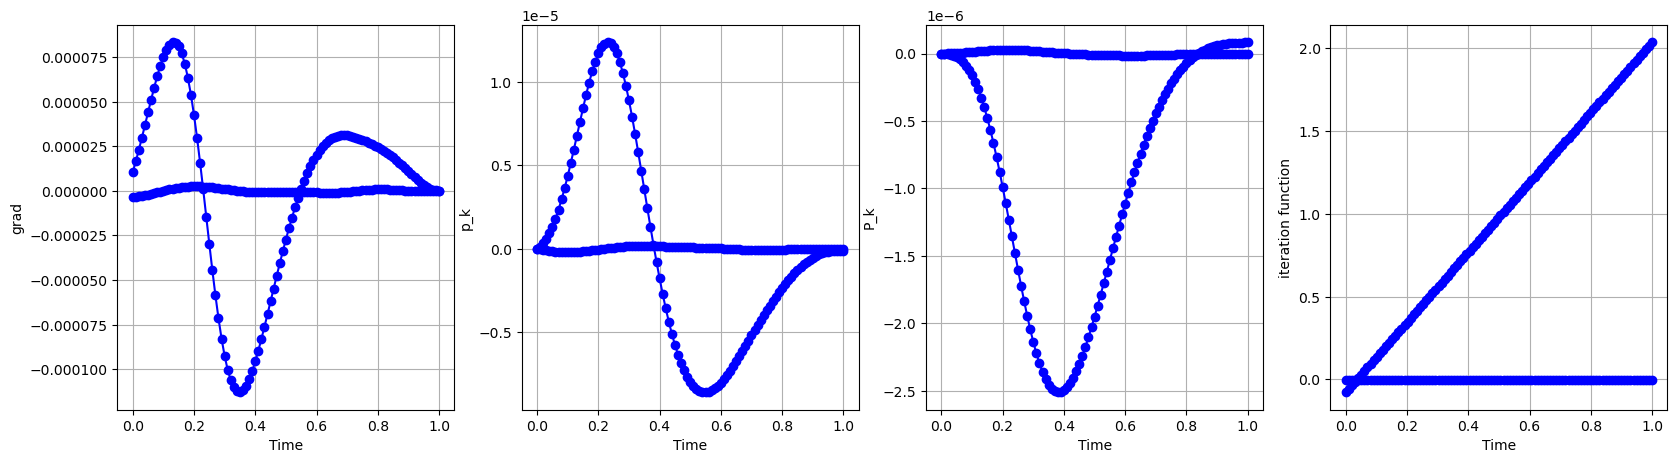

|p_max|/alpha:  1237.0159901954185 , |P_max|/beta:  25.098132453133836
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, weights:  [7.74041383e-09] slope:  [ 0.72943055 -0.00901272] y_shift [-0.10000708  0.00314943]
max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off

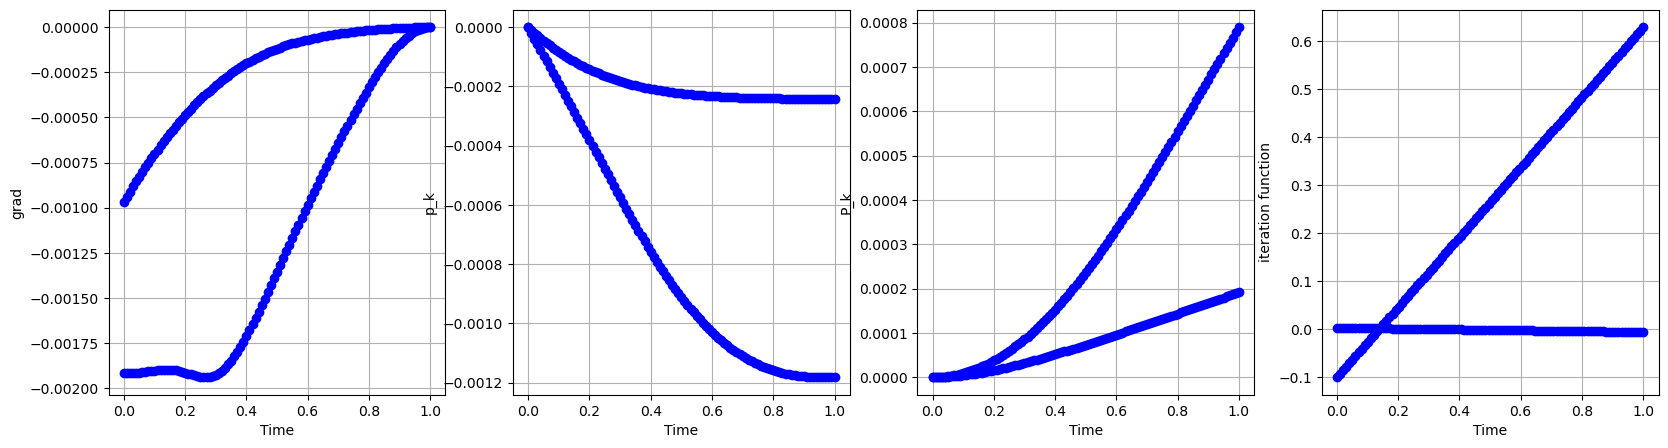

|p_max|/alpha:  120605.96533642123 , |P_max|/beta:  8007.718927259274
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1weights:  [0.

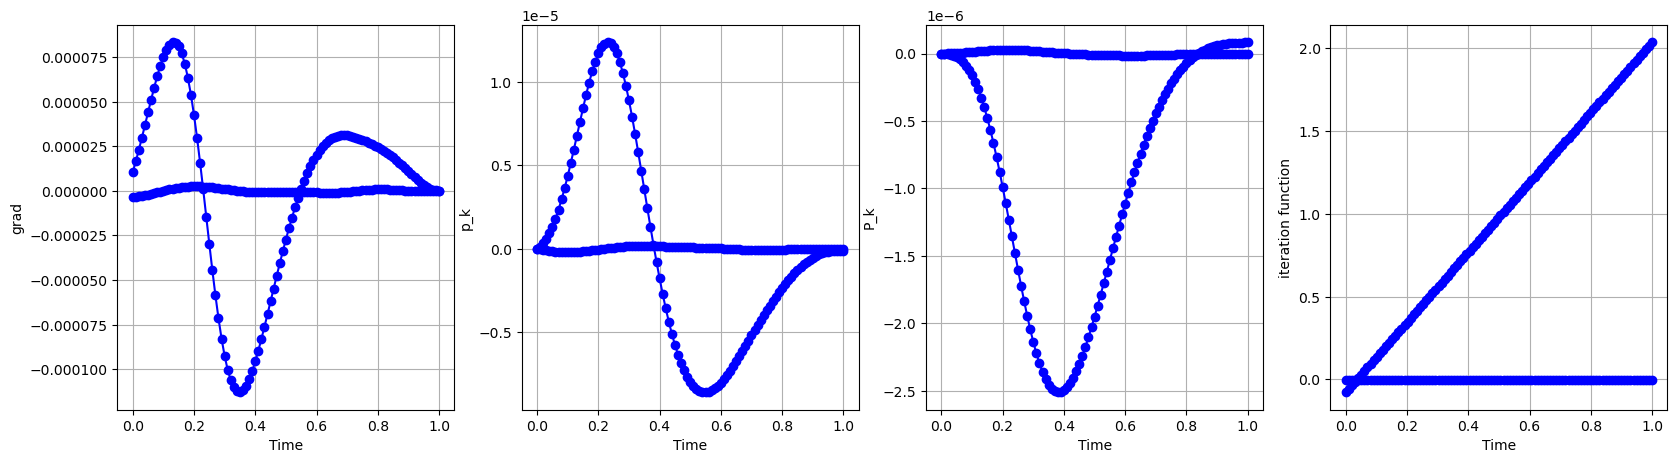

|p_max|/alpha:  1237.0159901953928 , |P_max|/beta:  25.098132453133086
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
weights:  [7.74041

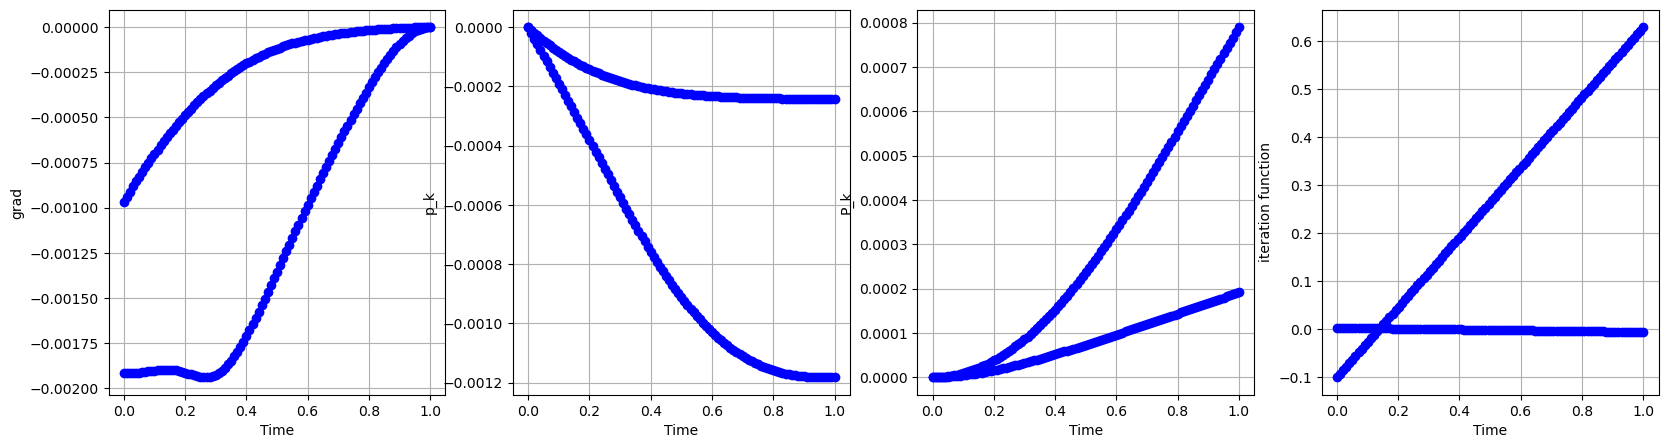

|p_max|/alpha:  120605.96533642917 , |P_max|/beta:  8007.718927259802
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

weights:  [0.] slope:  [2.11244692 0.00534241] y_shift [-0.07723527 -0.0060

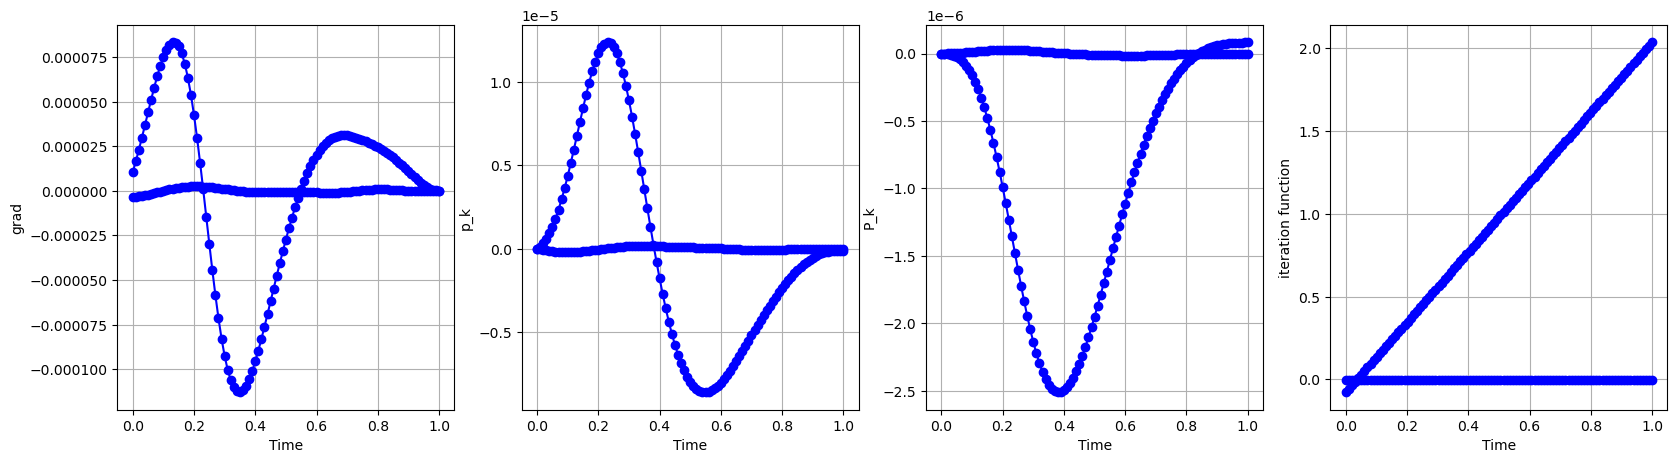

|p_max|/alpha:  1237.0159901954557 , |P_max|/beta:  25.098132453134887
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
weights:  [7.74041

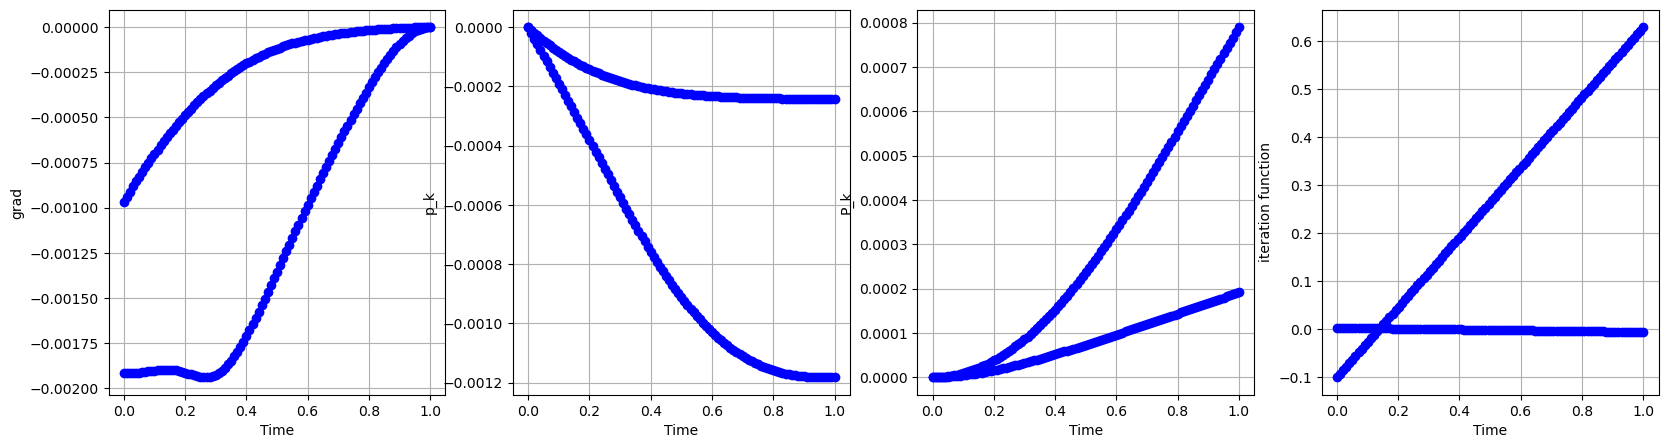

|p_max|/alpha:  120605.96533642577 , |P_max|/beta:  8007.718927259568
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
weights:  [0.] sl

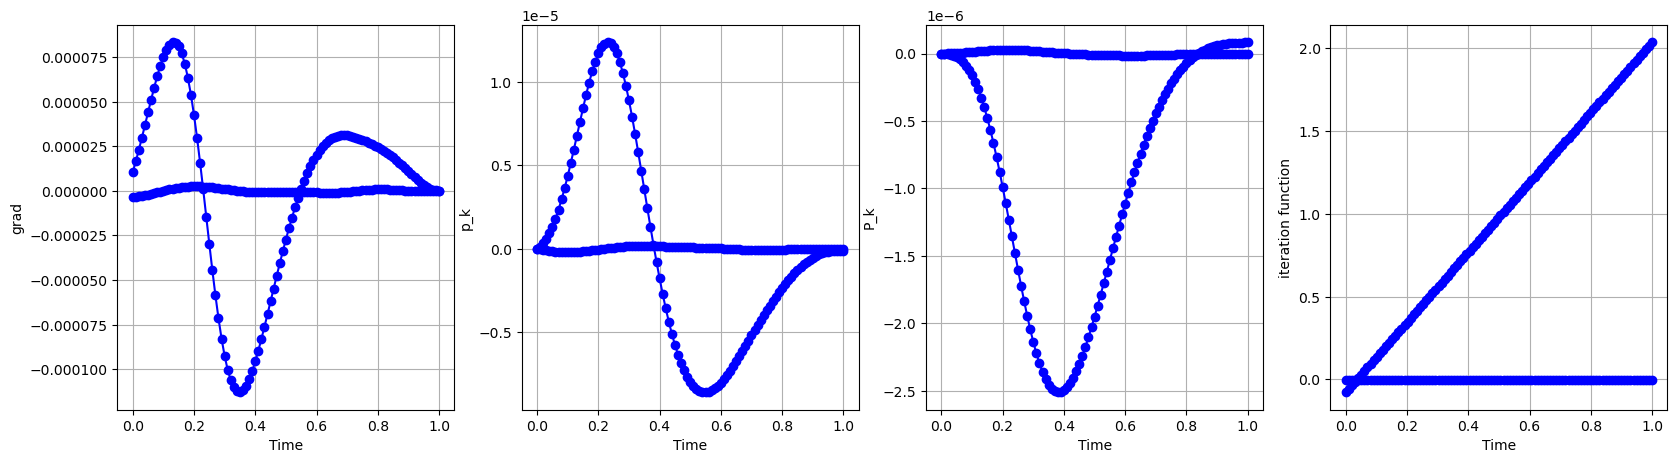

|p_max|/alpha:  1237.015990195579 , |P_max|/beta:  25.09813245313863
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          weights:  [7.74041383e-09] slope:  [ 0.72943055 -0.00901272] y_shift [-0.10000708  0.00314943]
eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, 

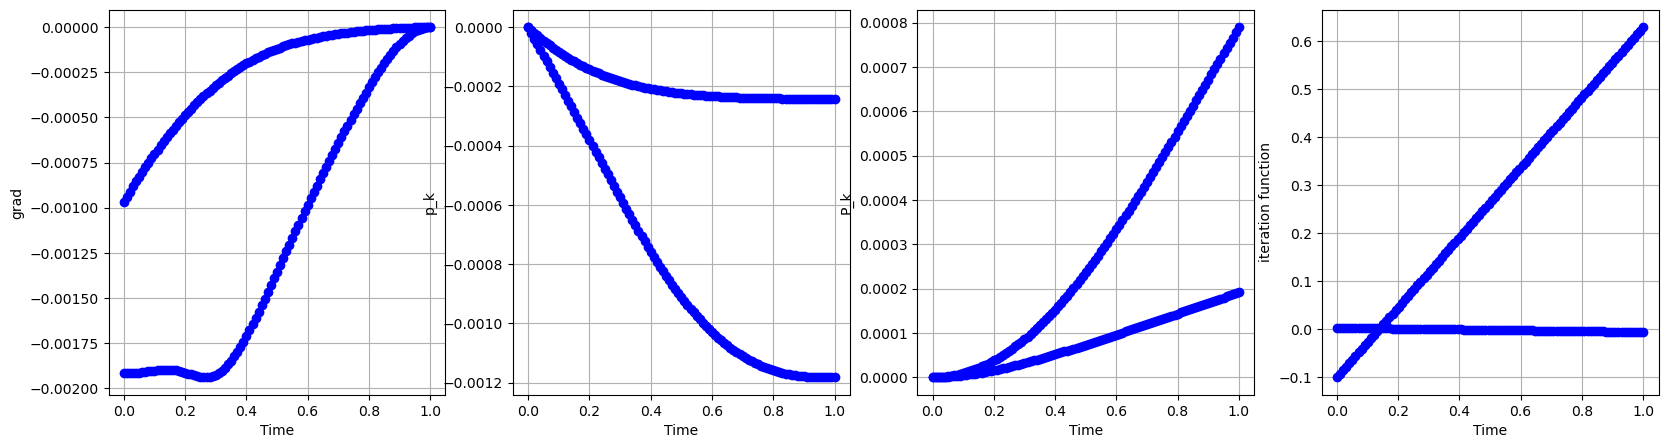

|p_max|/alpha:  120605.96533642628 , |P_max|/beta:  8007.718927259616
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2364e-03

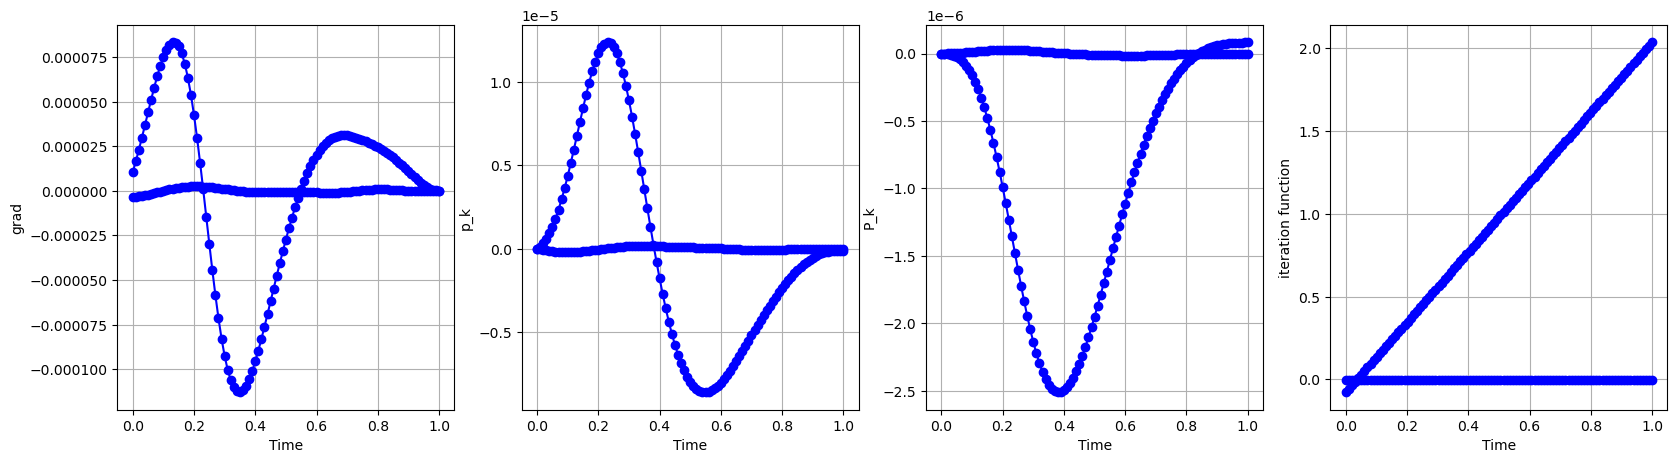

|p_max|/alpha:  1237.0159901955199 , |P_max|/beta:  25.09813245313689
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2525e-03we

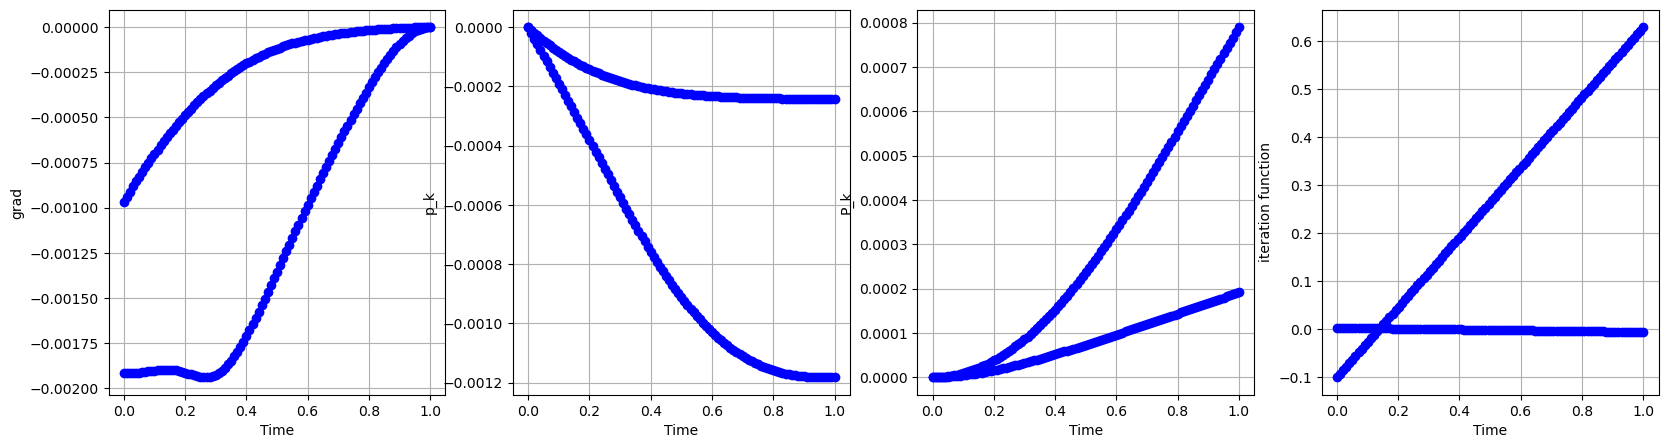

|p_max|/alpha:  120605.96533642494 , |P_max|/beta:  8007.71892725952
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
weights:  [0.] slope:  [2.11244692 0.00534241] y_shift [-0.07723527 -0.00606252]
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: 

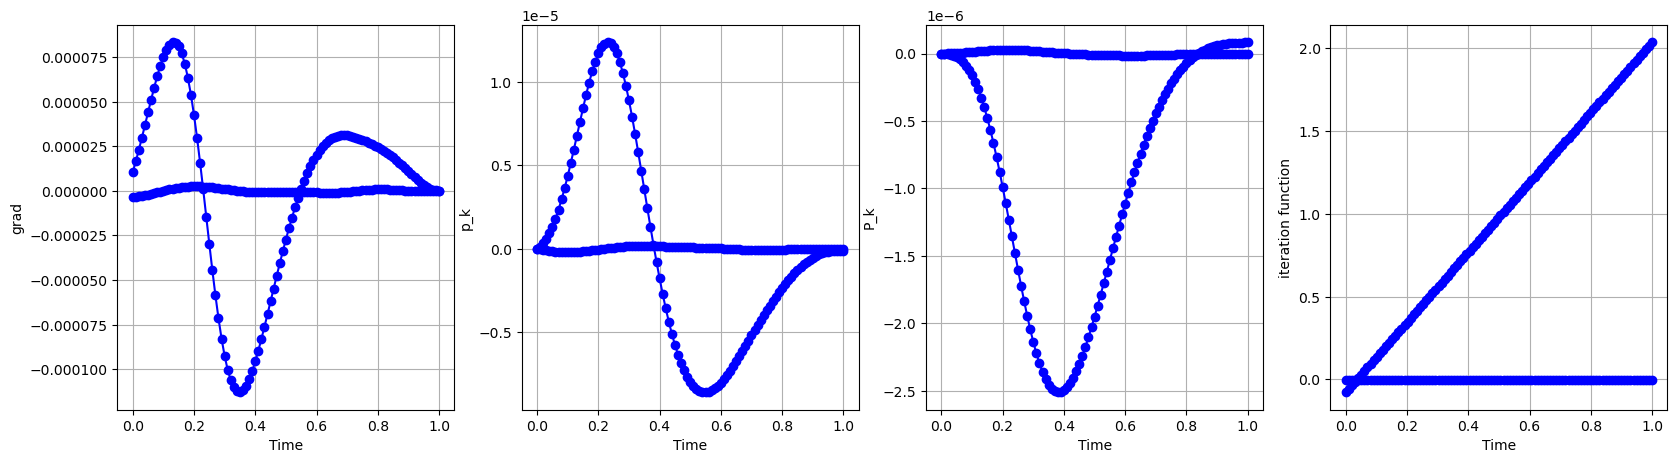

|p_max|/alpha:  1237.0159901954958 , |P_max|/beta:  25.098132453136095
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
weights:  [7.74041

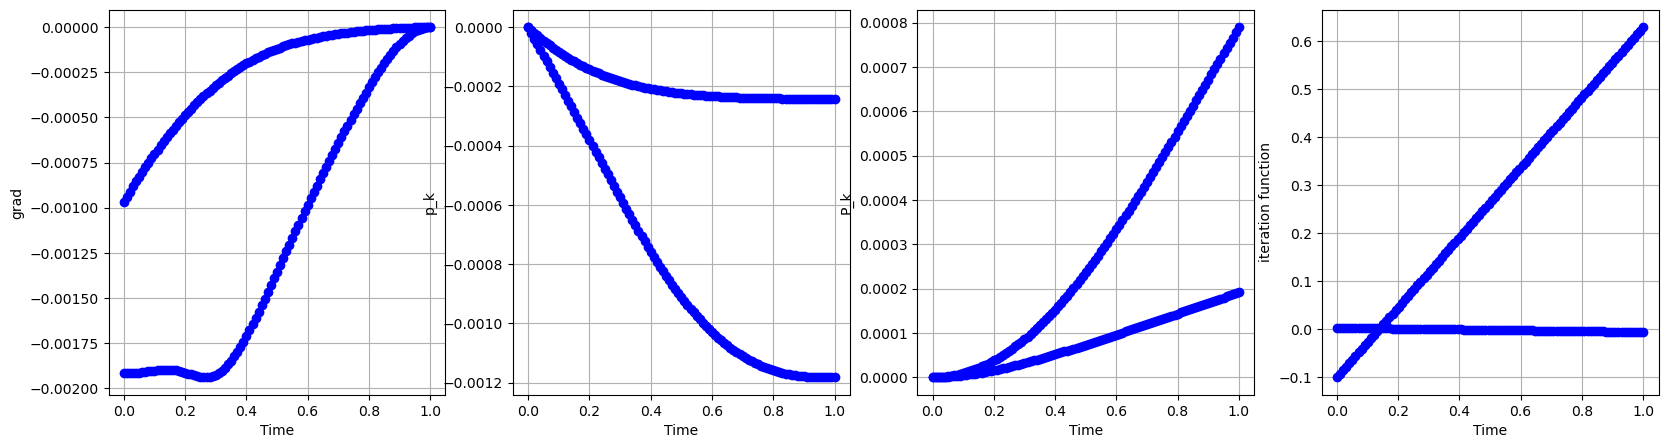

|p_max|/alpha:  120605.96533643565 , |P_max|/beta:  8007.718927260226
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          weights:  [0.] slope:  [2.11244692 0.00534241] y_shift [-0.07723527 -0.00606252]
eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit:

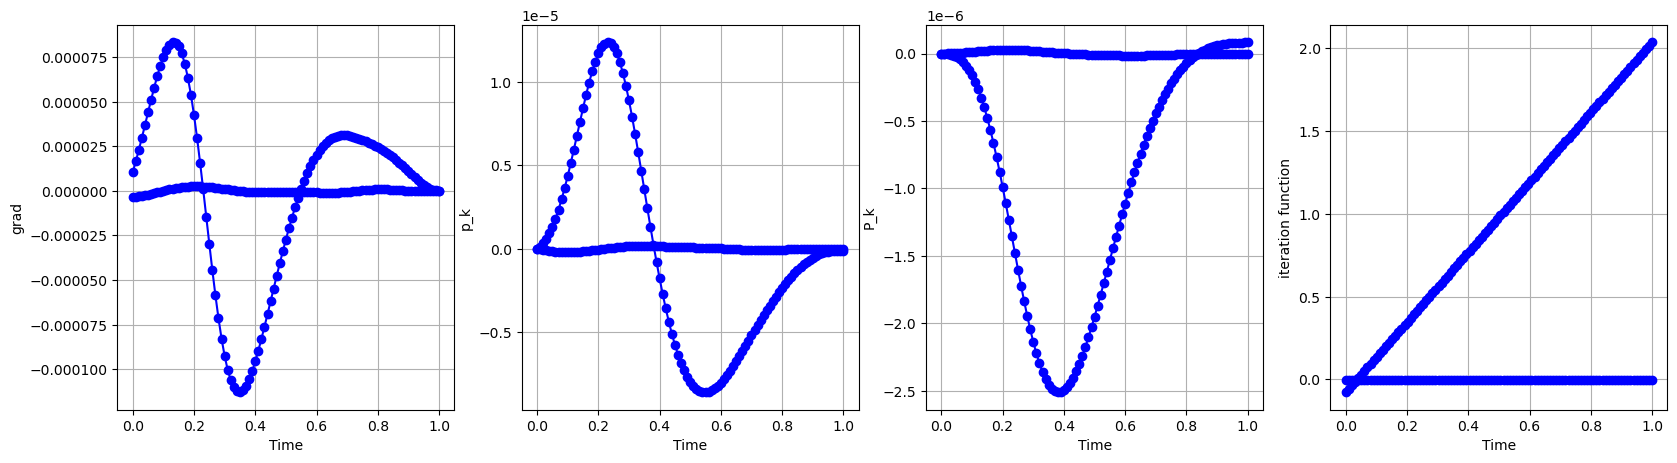

|p_max|/alpha:  1237.0159901954835 , |P_max|/beta:  25.098132453135744
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
weights:  [7.74041

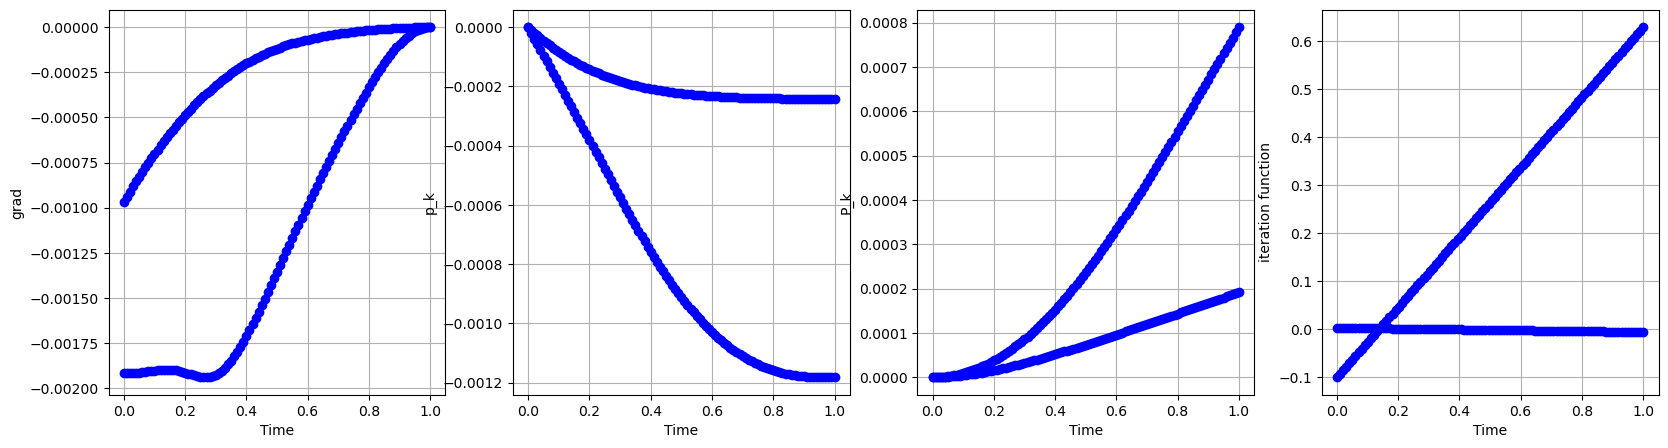

|p_max|/alpha:  120605.96533643066 , |P_max|/beta:  8007.718927259899
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldlweights:  [0.] slope:  [2.11244692 0.00534241] y_shift [-0.07723527 -0.00606252]
,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit:

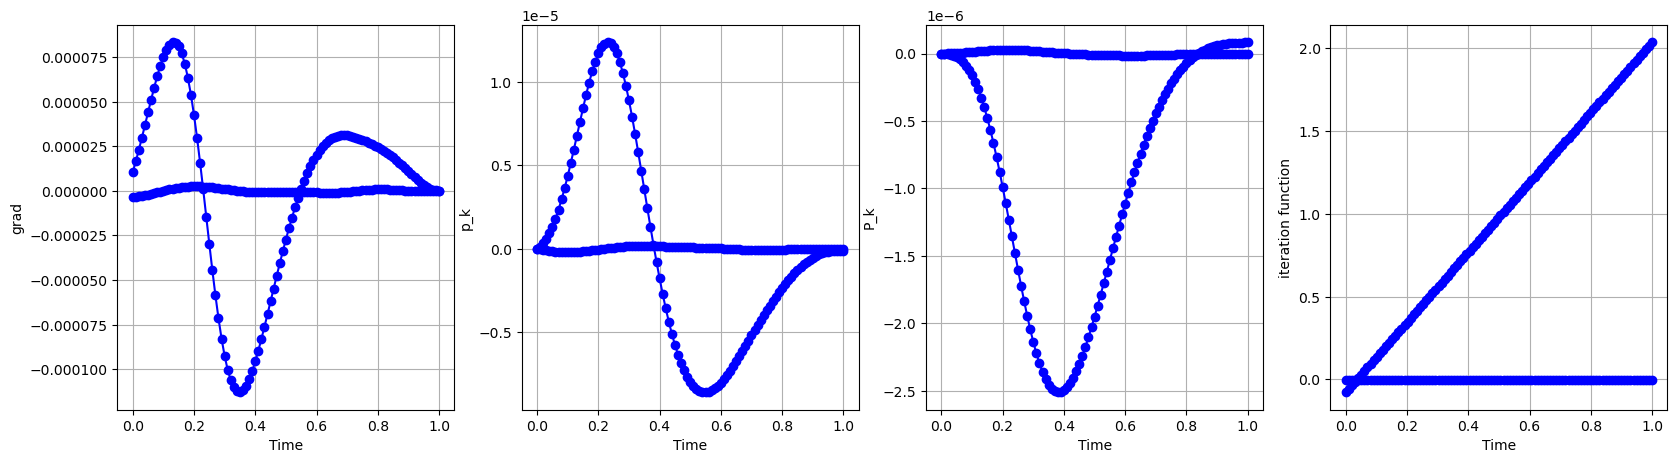

|p_max|/alpha:  1237.0159901955133 , |P_max|/beta:  25.098132453136635
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

weights:  [7.74041383e-09] slope:  [ 0.72943055 -0.00901272] y_shift [-0.100

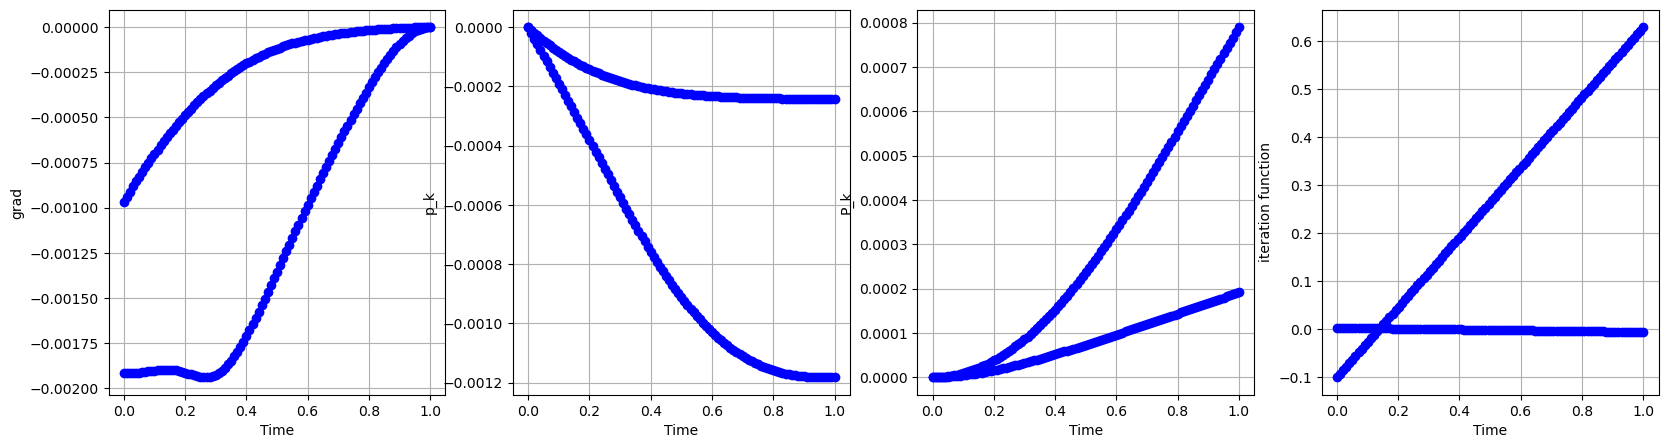

|p_max|/alpha:  120605.96533643402 , |P_max|/beta:  8007.718927260126
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1weights:  [0.

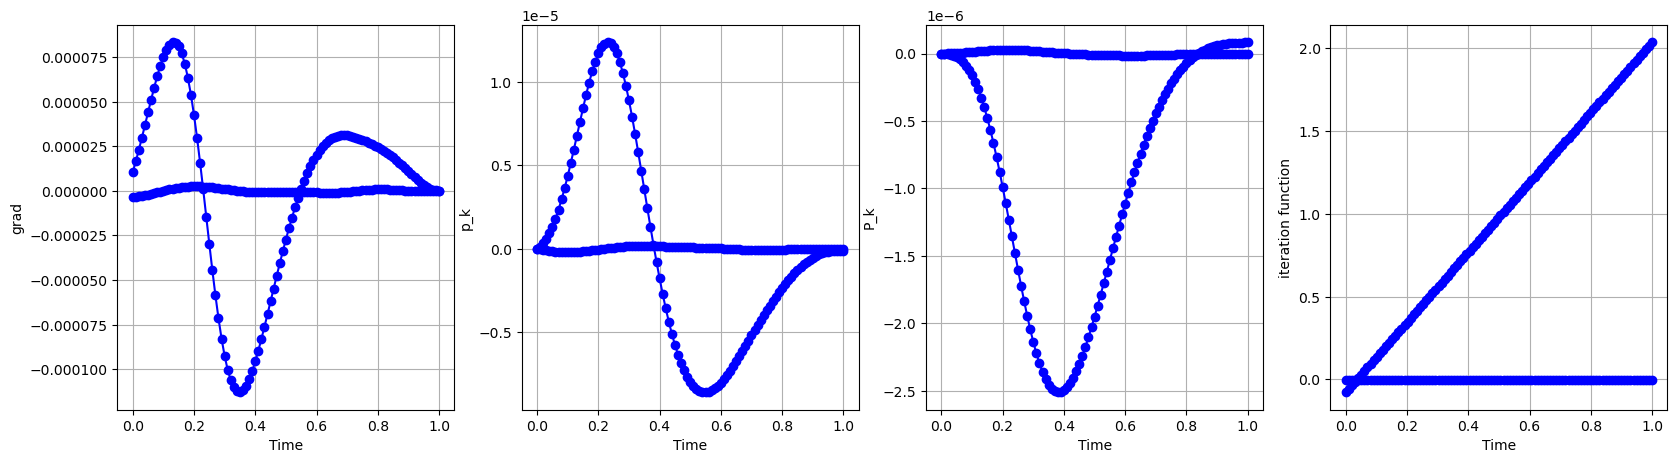

|p_max|/alpha:  1237.0159901954623 , |P_max|/beta:  25.0981324531351
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
weights:  [7.7404138

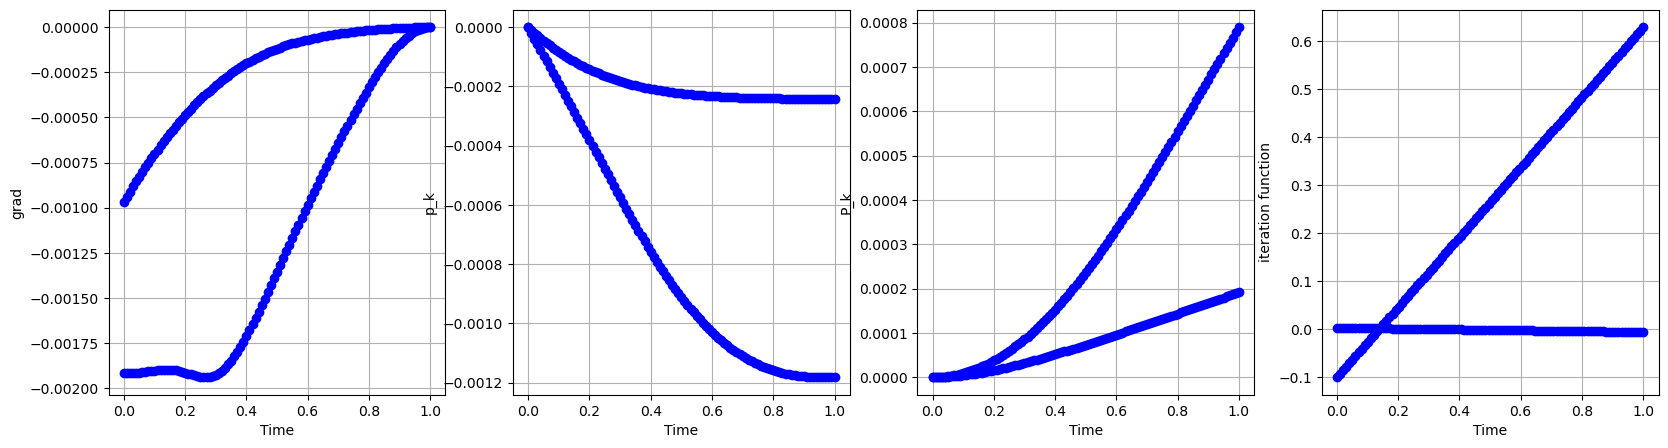

|p_max|/alpha:  120605.96533642671 , |P_max|/beta:  8007.718927259641
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
weights:  [0.] slope:  [2.11244692 0.00534241] y_shift [-0.07723527 -0.00606252]
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit:

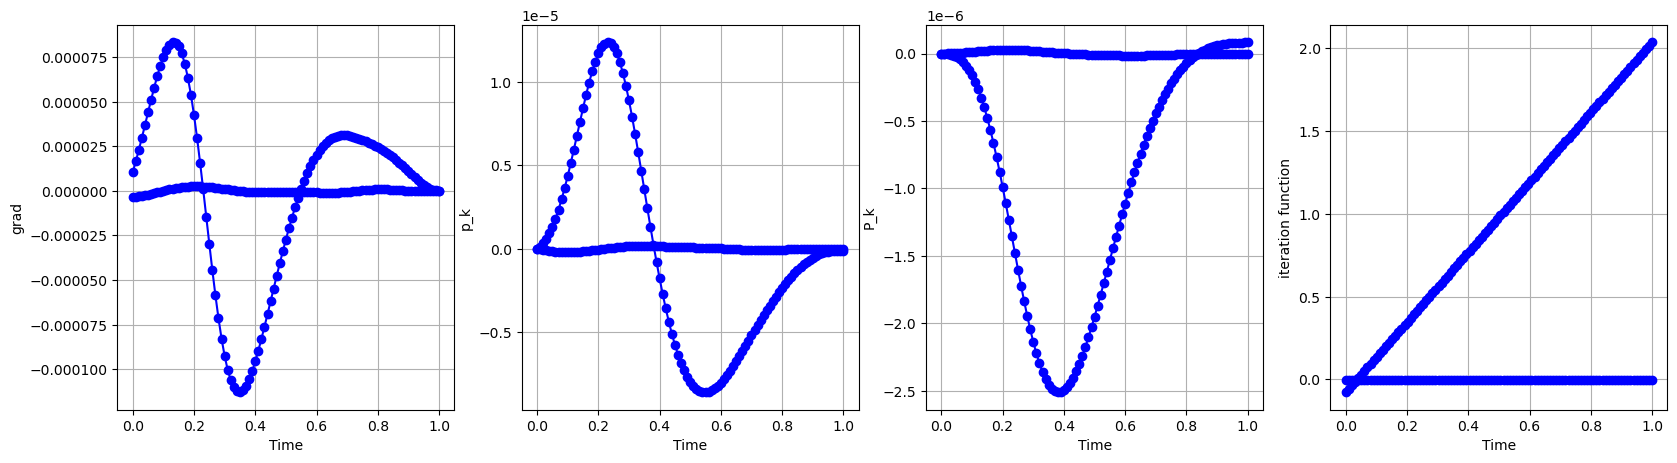

|p_max|/alpha:  1237.0159901955192 , |P_max|/beta:  25.09813245313678
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          weights:  [7.74041383e-09] slope:  [ 0.72943055 -0.00901272] y_shift [-0.10000708  0.00314943]
rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off,

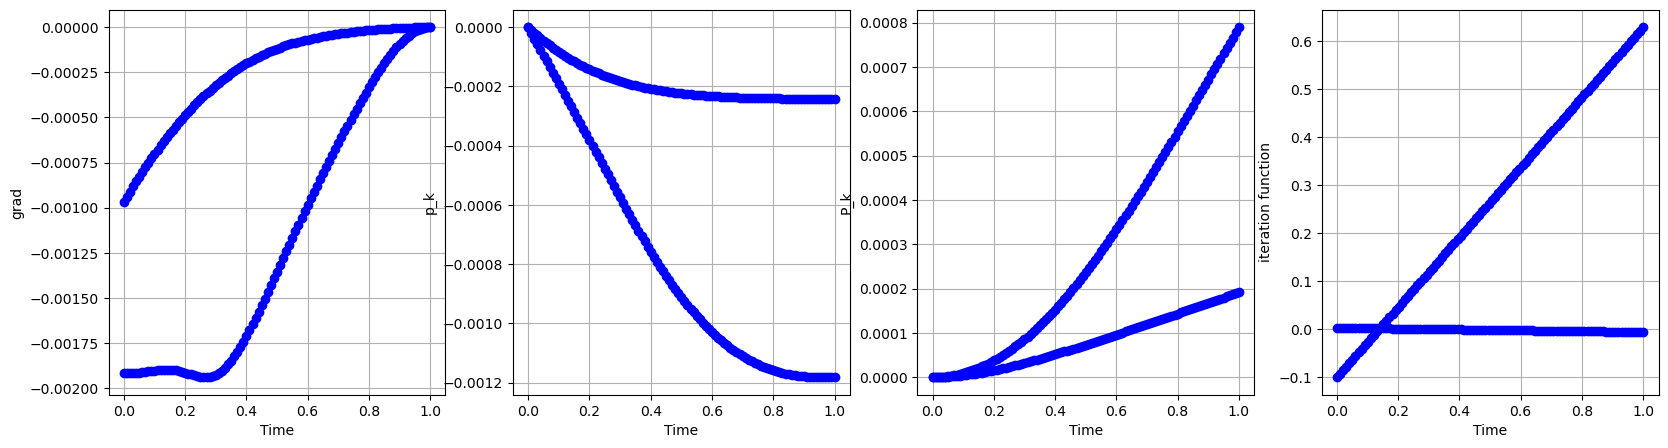

|p_max|/alpha:  120605.96533642875 , |P_max|/beta:  8007.718927259769
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2364e-03

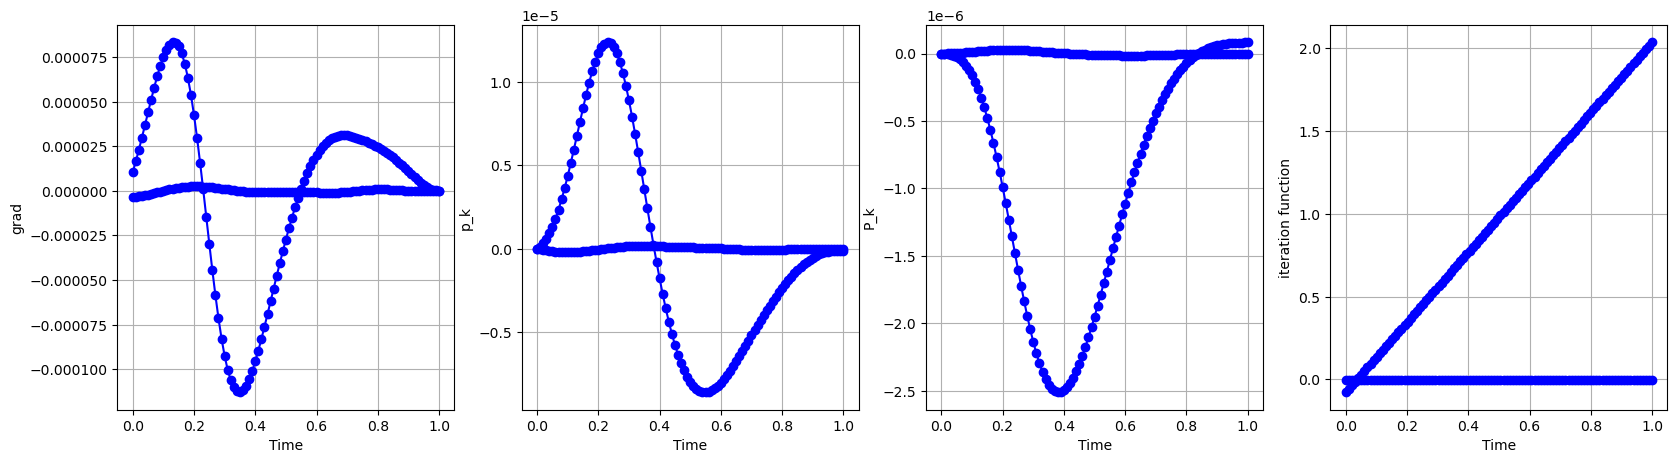

|p_max|/alpha:  1237.0159901955399 , |P_max|/beta:  25.098132453137456
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2525e-03 

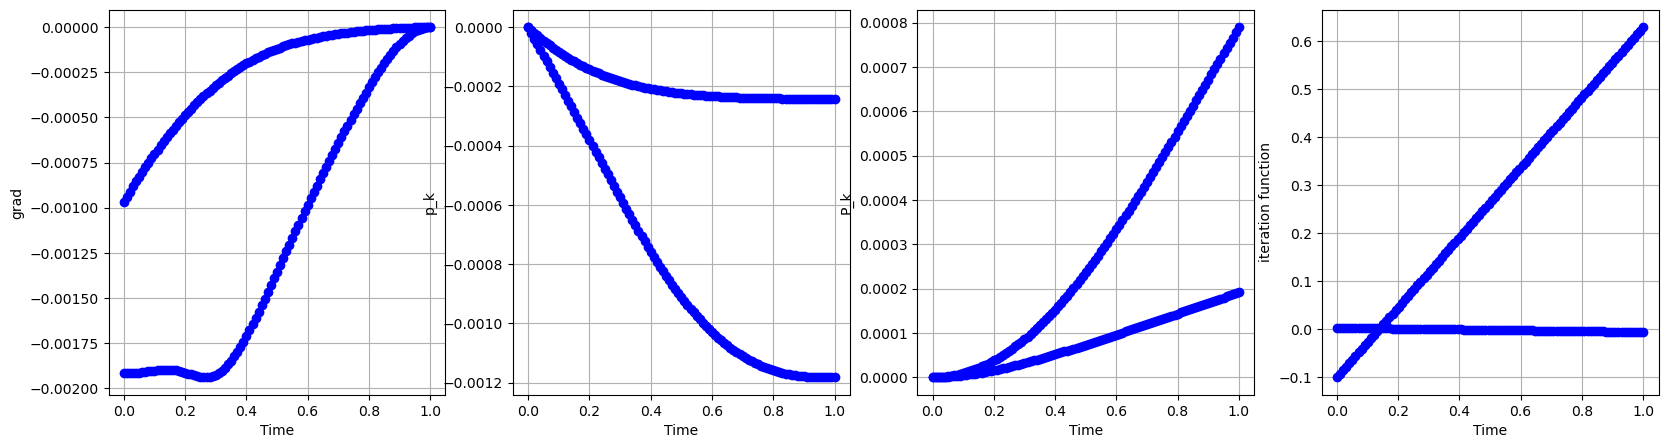

|p_max|/alpha:  120605.9653364291 , |P_max|/beta:  8007.718927259809
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2364e-03 

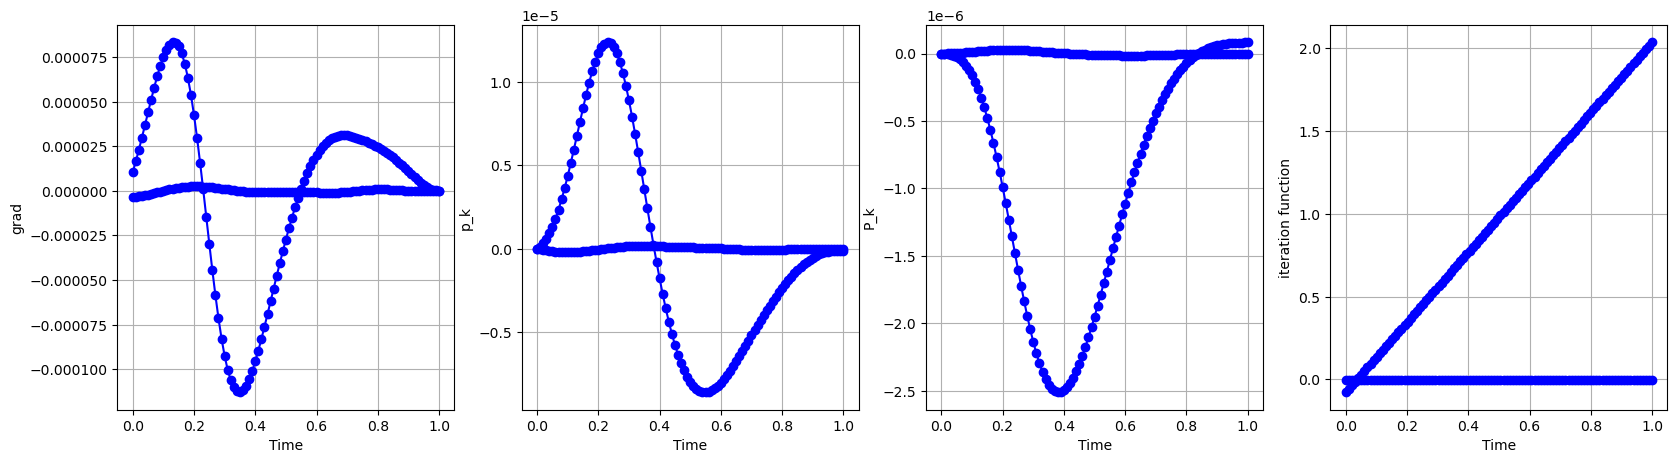

|p_max|/alpha:  1237.015990195427 , |P_max|/beta:  25.098132453134063
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
weights:  [7.74041383e-09] slope:  [ 0.72943055 -0.00901272] y_shift [-0.10000708  0.00314943]
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off,

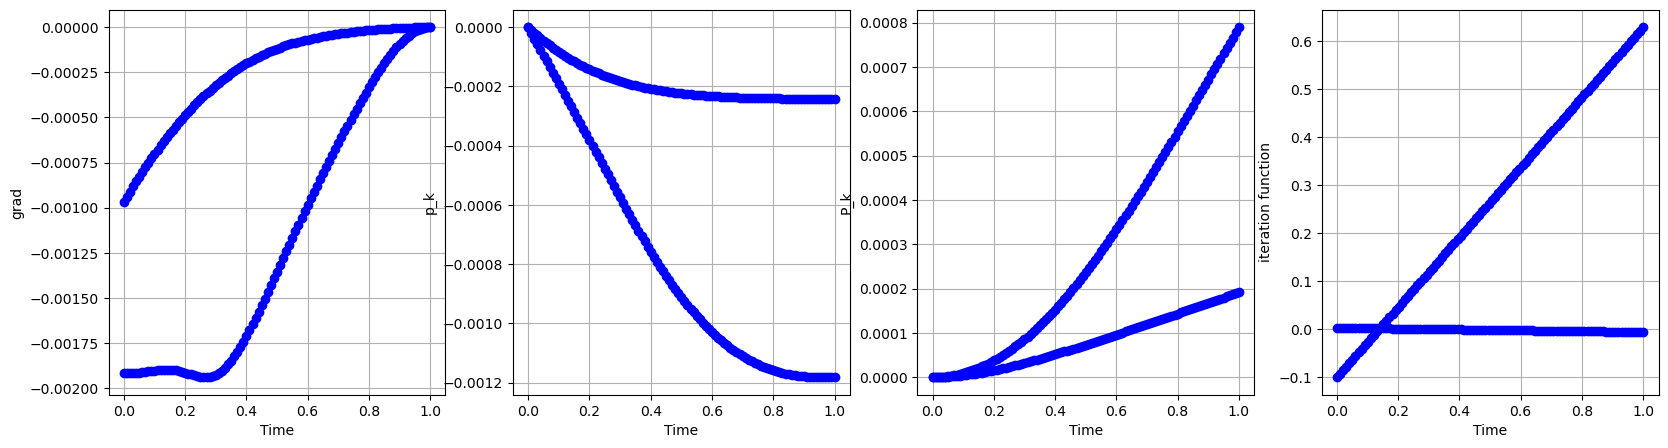

|p_max|/alpha:  120605.9653364318 , |P_max|/beta:  8007.718927259973
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
weights:  [0.] slo

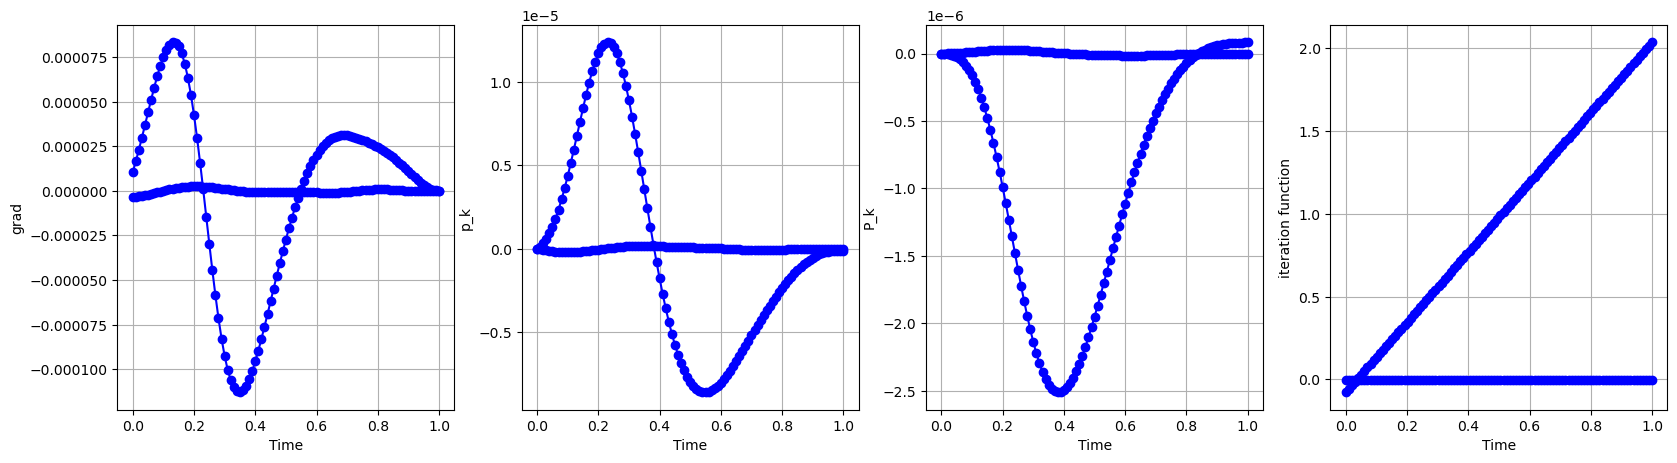

|p_max|/alpha:  1237.015990195406 , |P_max|/beta:  25.098132453133434
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, weights:  [7.74041383e-09] slope:  [ 0.72943055 -0.00901272] y_shift [-0.10000708  0.00314943]

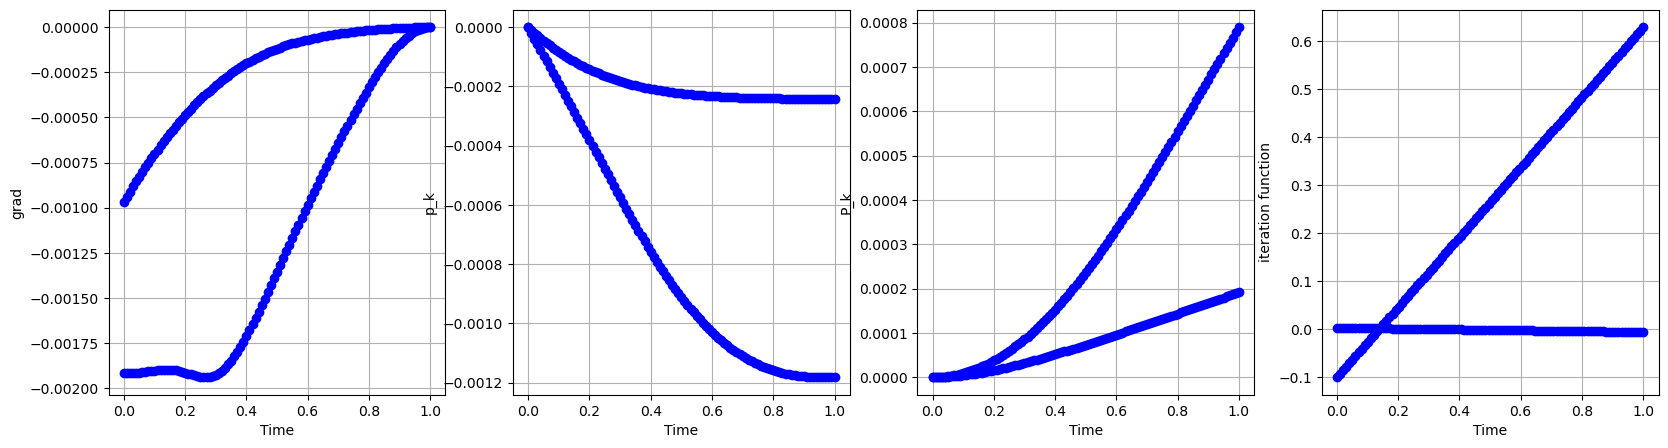

|p_max|/alpha:  120605.96533643777 , |P_max|/beta:  8007.718927260377
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2364e-03

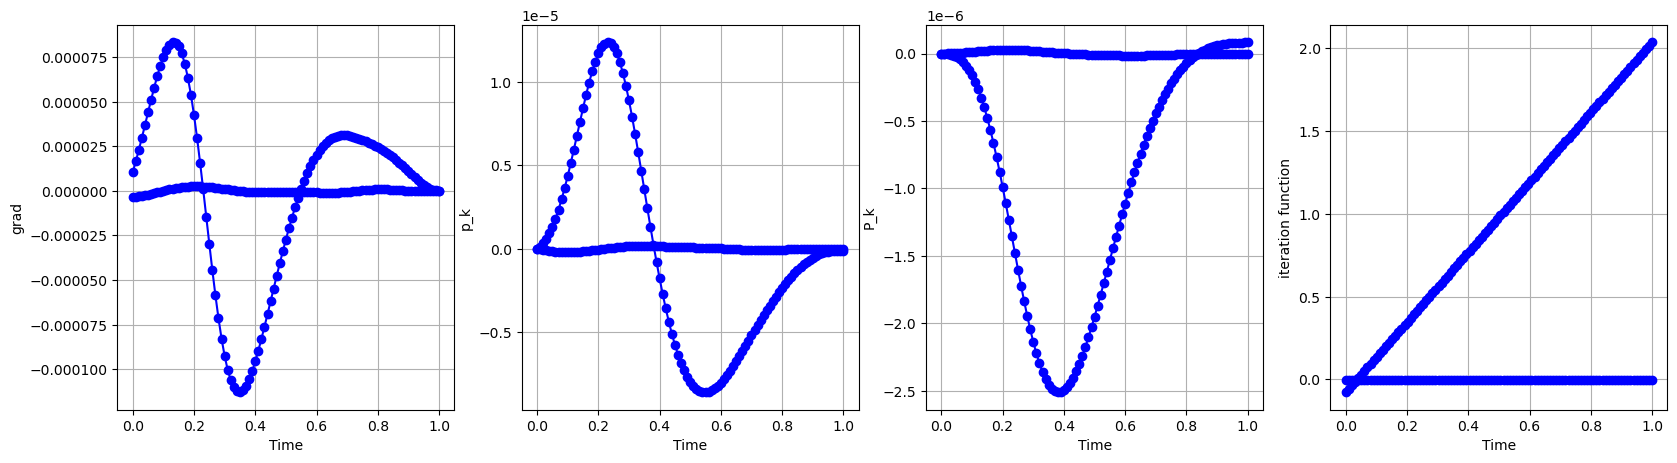

|p_max|/alpha:  1237.0159901954387 , |P_max|/beta:  25.098132453134475
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

weights:  [7.74041383e-09] slope:  [ 0.72943055 -0.00901272] y_shift [-0.100

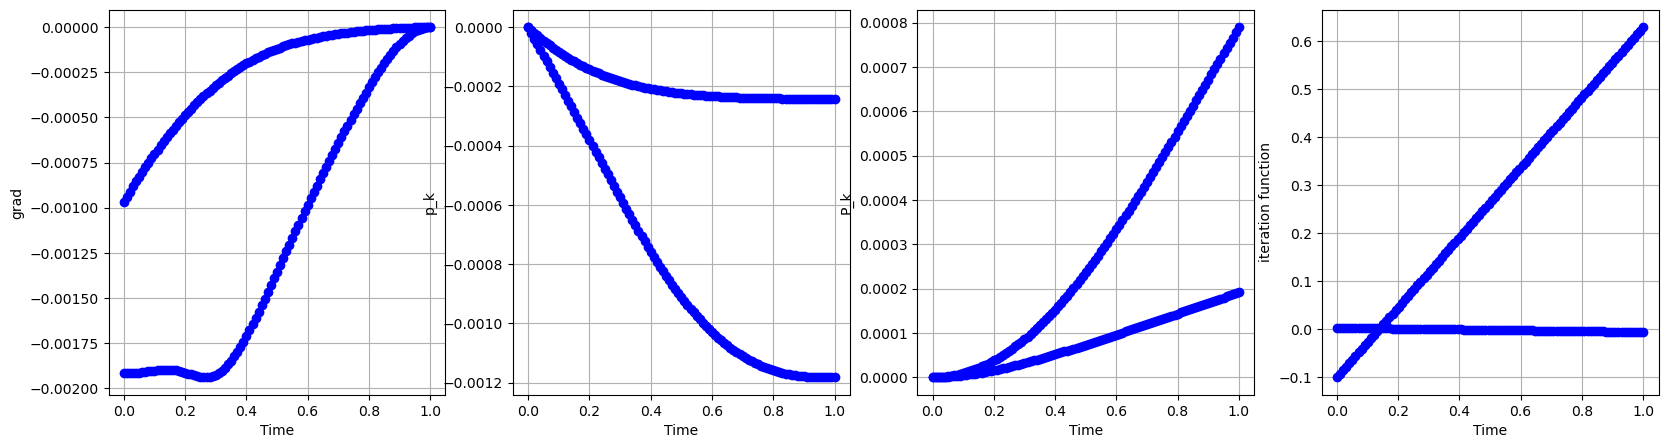

|p_max|/alpha:  120605.96533642785 , |P_max|/beta:  8007.718927259721
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
weights:  [0.] sl

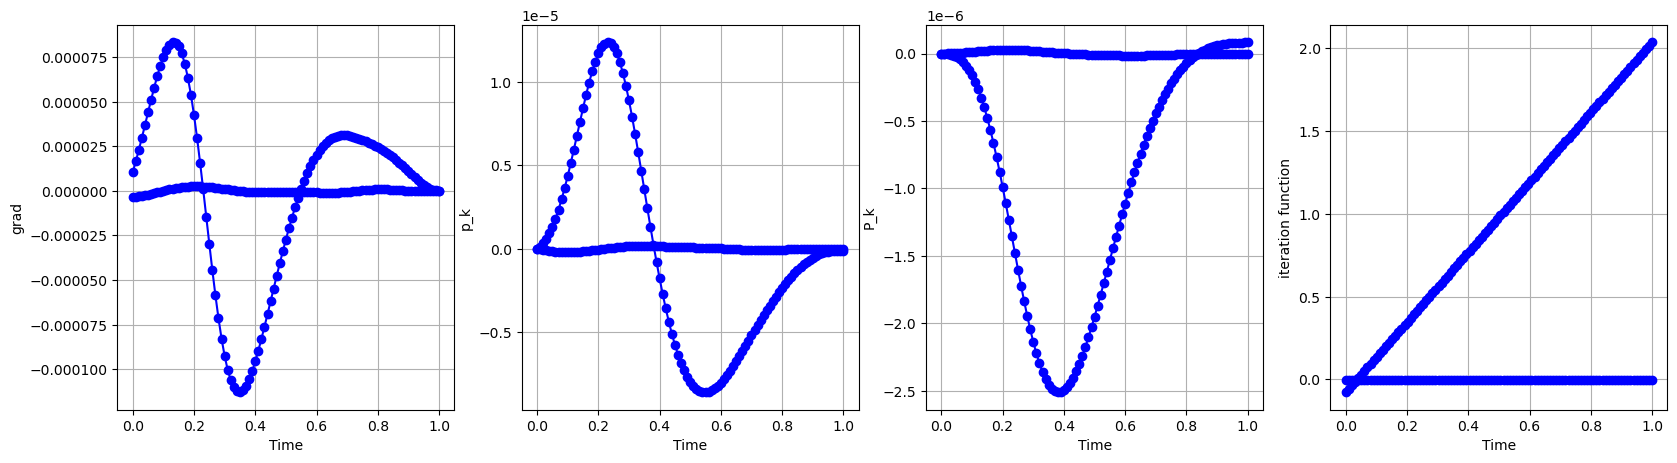

|p_max|/alpha:  1237.01599019549 , |P_max|/beta:  25.098132453135968
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2525e-03   

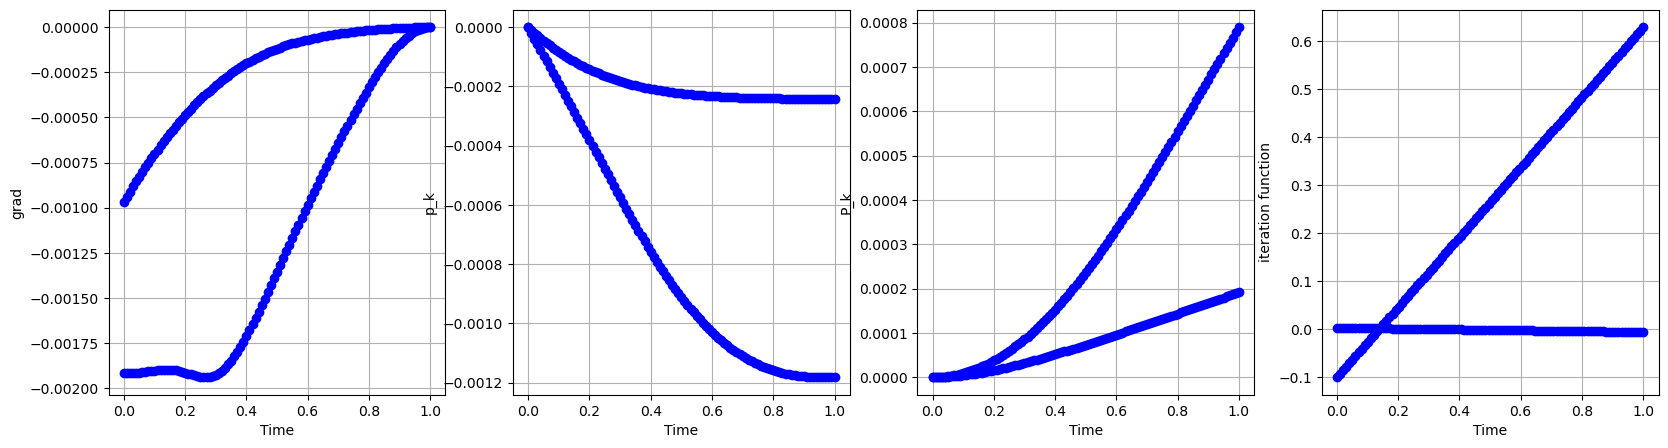

|p_max|/alpha:  120605.96533642644 , |P_max|/beta:  8007.718927259624
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rhoweights:  [0.] slope:  [2.1124

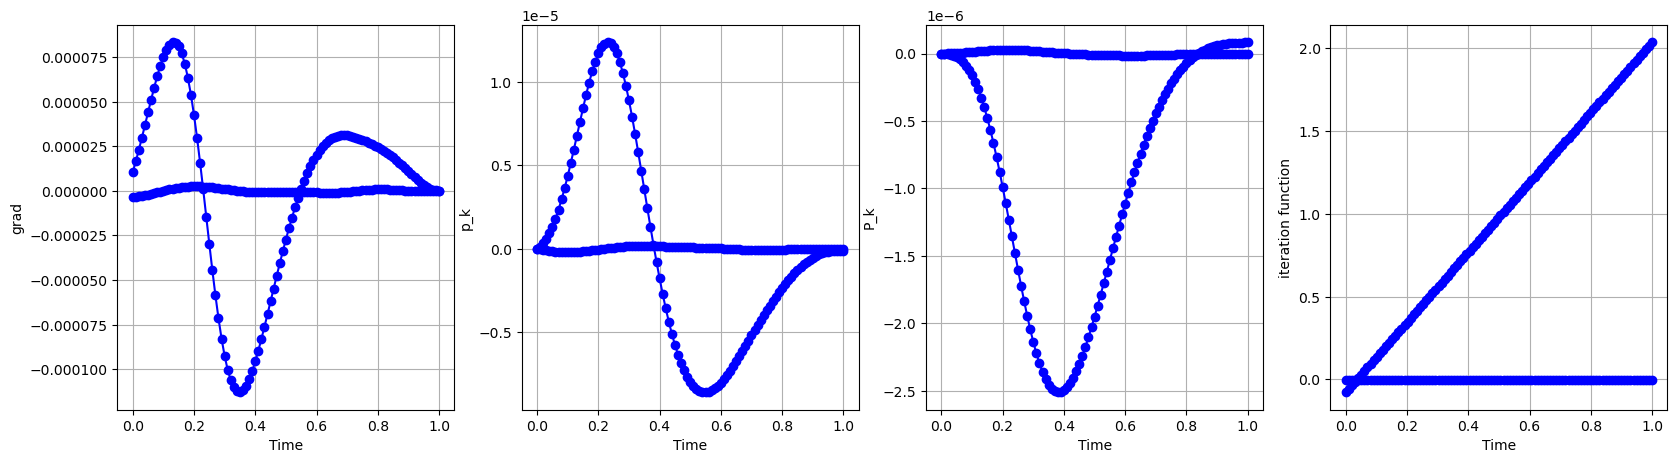

|p_max|/alpha:  1237.0159901954903 , |P_max|/beta:  25.098132453135936
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2525e-03w

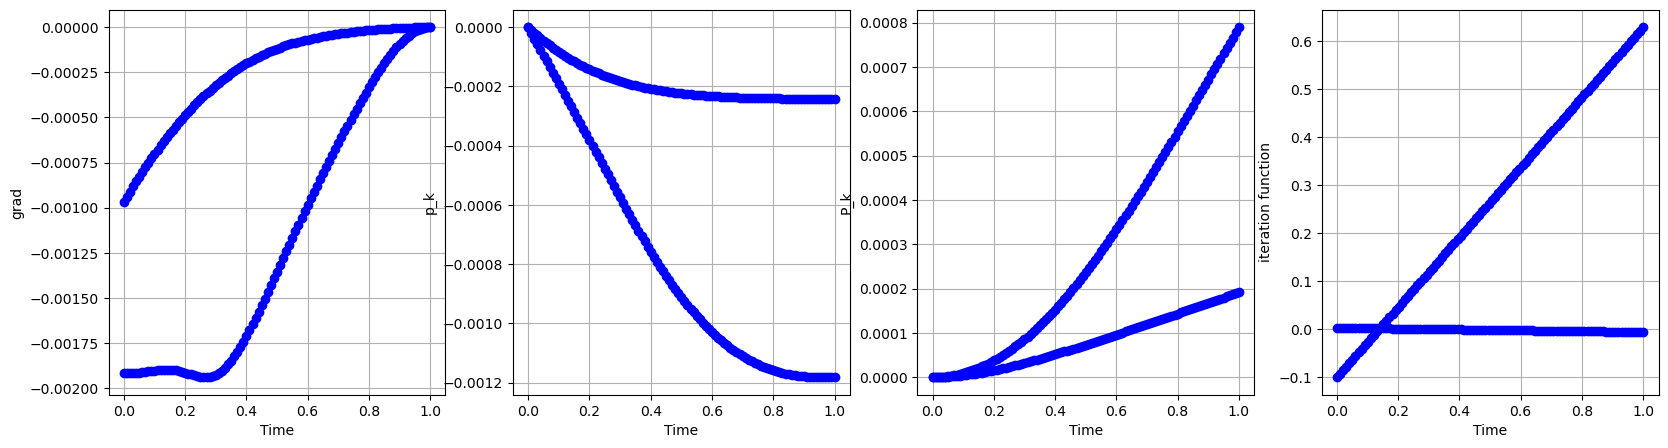

|p_max|/alpha:  120605.96533642782 , |P_max|/beta:  8007.718927259721
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1weights:  [0.

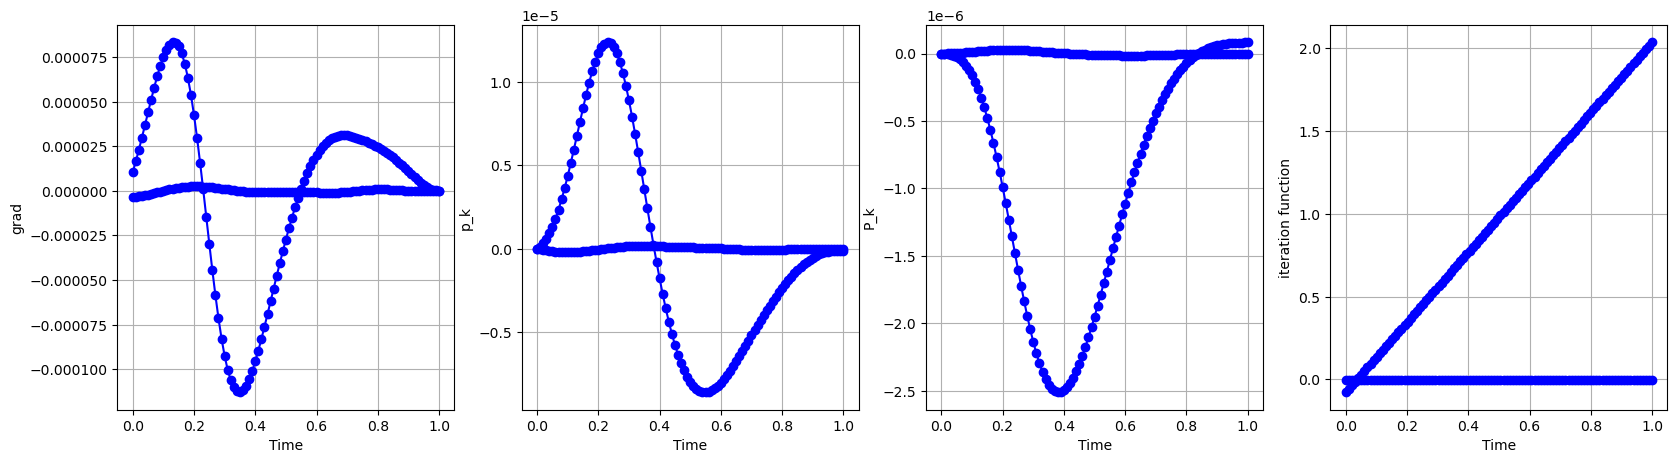

|p_max|/alpha:  1237.0159901954357 , |P_max|/beta:  25.098132453134323
x_S:  0.23 x_K:  0.38 
New point: sigma= [0.99999622 0.00275056] x_0 = 0.23 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1weights:  [7.7

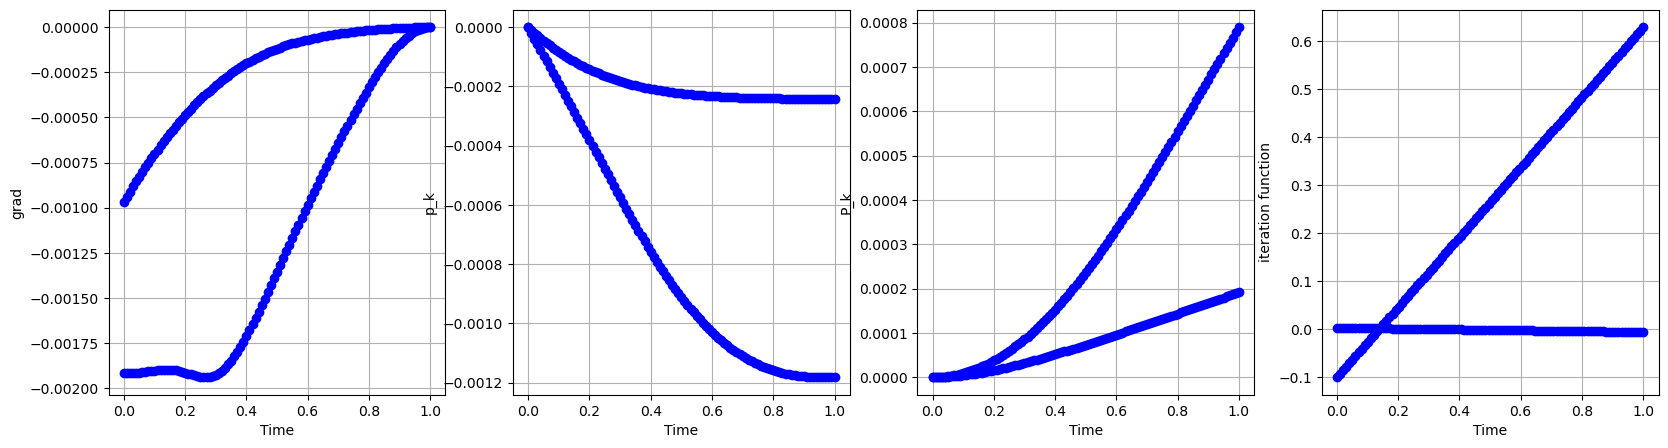

|p_max|/alpha:  120605.96533642913 , |P_max|/beta:  8007.718927259807
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.9797517  -0.20021639] x_0 = 0.99 , type = 0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 5
          nnz(P) + nnz(A) = 20
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2364e-03

In [3]:
def algorithm(active_set: List[ExtremalPoint], weights: np.ndarray, slope: np.ndarray, y_shift: np.ndarray, params):
    hesse = HesseMatrix(active_set, params)
    constraintViolation = np.empty(params.maxIterations)
    constraintViolation[:] = np.nan
    print('Objective upper bound: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
    weights, slope, y_shift = computeOSQPStep(weights, slope, y_shift, active_set, hesse, params)
    print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
    print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
    for k in range(params.maxIterations):
        printIterationInfo(k, active_set, weights, slope, y_shift, hesse.matrix)
        u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
        discreteDf = calculateDiscreteGradient(active_set, weights, slope, y_shift, hesse.standard_adjoints, params)
        p_k = integrateVectorFunction(discreteDf, params)
        P_k = -integrateVectorFunction(p_k, params)
        
        fig, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
        plot_array(discreteDf, params.T, label='grad', ax=ax1)
        plot_array(p_k, params.T, label='p_k', ax=ax2)
        plot_array(P_k, params.T, label='P_k', ax=ax3)
        plot_array(np.array([u_k(t) for t in discretInterval]), params.T, label='iteration function', ax=ax4)
        mpl.pyplot.show()
        
        idx_S = getIdxMax(p_k, active_set, type=0)
        idx_K = getIdxMax(P_k, active_set, type=1)
        norm_p_max = np.linalg.norm(p_k[idx_S])
        norm_P_max = np.linalg.norm(P_k[idx_K])
        
        print('|p_max|/alpha: ', norm_p_max / params.alpha,  ', |P_max|/beta: ', norm_P_max / params.beta)
        constraintViolation[k] = max(norm_p_max / params.alpha, norm_P_max / params.beta) - 1
        if (max(norm_p_max / params.alpha, norm_P_max / params.beta) <= 1):
            break
        if norm_p_max / params.alpha >= norm_P_max / params.beta:
            active_set.append(ExtremalPoint(p_k[idx_S] / norm_p_max, idx_S * params.dt, type=0, params=params))
        else:
            active_set.append(ExtremalPoint(P_k[idx_K] / norm_P_max, idx_K * params.dt, type=1, params=params))

        print('x_S: ', idx_S * params.dt, 'x_K: ', idx_K * params.dt, '\nNew point: sigma=', active_set[-1].sigma, 'x_0 =', active_set[-1].x_0, ', type =', active_set[-1].type)
        hesse.extendMatrix(active_set[-1])
        weights, slope, y_shift = computeOSQPStep(np.concatenate((weights, np.array([0.]))), slope, y_shift, active_set, hesse, params)
        print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
        active_set, weights = pruneActiveSet(active_set, weights, params.pruneThreshold)
        hesse.pruneMatrix(active_set, weights)
        print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
    return weights, slope, y_shift, active_set, constraintViolation

active_set = []
ext1 = ExtremalPoint(np.array([1., 0]), x_0=0.25, type=0, params=params)
ext2 = ExtremalPoint(np.array([1., 0]), x_0=0.5, type=1, params=params)
weights = np.ones(len(active_set))
slope = np.ones(params.d)
y_shift = np.ones(params.d)
weights, slope, y_shift, active_set, constraintViolation = algorithm(active_set, weights, slope, y_shift, params)